In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from midas import m
from datetime import datetime, date
import altair as alt


In [4]:
import io
import subprocess
import os
import glob

import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
from sklearn.decomposition import PCA
import pickle
import re
import math
import plotnine as pn
import seaborn as sns
import glob
import subprocess
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from numpy import log
from collections import defaultdict,Counter
import re
import statsmodels
import warnings

# !pip install statannotations==0.4.0
# #!pip uninstall statannotations --yes
# from statannotations.Annotator import Annotator

warnings.filterwarnings("ignore")
pd.options.display.max_rows = None
pd.options.display.max_columns=None
pd.options.display.max_colwidth=None
work_dir="/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/CSO_call_on_RUO_samples_05032024"

In [7]:
ghdb = pd.read_csv(f"{work_dir}/CTM_SOW01_transfer2_10052022_tb_changed_all_cols.csv", header=1)
ghdb.head()
fc_dir = row["fc_dir"].replace("/ghds", "/ghsfa/projects") 
flowcell_id = row["runid"]

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Sample Type,Sample Subtype,(Nof1) Cancer Type,Cancer Stage,Tumor Type,Molecular Marker,Patient age at Sample Collection,Patient Year of Birth (YYYY),Patient Sex,Patient Pregnancy / Transplant history,Patient Treatment Information,Investigator / PI,Site Number,customersampleid,requestcreatedt,sample_received_date,cancerstage,index,index2,Description,Index Name,fc_dir,WellId,From [bp],To [bp],Average Size [bp],Conc. [ng/µl],Region Molarity [nmol/l],% of Total,Batch_ID,call,ldt_reportable,ruo_reportable,Final_RUO_call,Start,on_OMNI,variant_comment,is_deletion,molecule_count,estimated_copy_number,region_methyl_score,region_methyl_molecules,hrd_status,prob_hrd_pos,lst_score,loh_score,methyl_pred_type,sample_LR_methyl_score,methyl_score_bladder_lr,methyl_score_breast_lr,methyl_score_crc_lr,methyl_score_lung_lr,msi_score,hyper_flag,runid,chry_nonsingleton,cnv_hyper_score,contam_vscore,estimated_contam_level,hotspot_non_singleton_coverage,hotspot_umol_gc_iqr,hypo_on_target_rate,mapd,methyl_hyper_pos_highcg_count,methyl_neg_capture,methyl_pos_capture_max,methyl_pos_capture_min,sample_contamination_pct,warning
0,CTMX-001,PTG_651325_01,A0529144,B00169848,PTG_651325,NaN,1.0,SUCCESS,NaN,SNV,NaN,KDM5C,X,53222195.0,26.0,R1546Q,C>T,c.4637G>A,NM_004187.5,100.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV64768404,rs139569882,Benign/Likely_benign,100779.0,NaN,NaN,1430.0,11.31,NaN,-1.355,Detected,0.002573,14.23,Low,Not Detected,22.685,2.0,0,NaN,NaN,10/06/2022,Laryngopharynx squamous cell carcinoma,Not Applicable,Not Applicable,Plasma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PTG_651325_01,2022-06-13T10:31:44.000Z,2022-06-08T12:00:00.000Z,NaN,TCCGGTGTGA,TAGTTAGAGA,Shortened_Targeted_SEQ:Unknown:Pharma,EIO_PlateD_C5,/ghds/omni_v2/flowcells/220729_A01744_0028_BHHK2YDSX3_PROD46_AP2.Sirius-1.0.0.740-master-2ec4e96_20220801-111833,C5,100,450,209,0.349,2.69,27.19,PROD-46,1.0,0,1,1,53222194.0,Yes,NaN,NaN,NaN,NaN,NaN,NaN,HRD_Neg,0.205054,0,1,crc,22.481467,14.371206,0.772622,22.481467,12.393539,2,NaN,220729_A01744_0028_BHHK2YDSX3,0.0,1.0,4.0,0.00124,2435.0,1.427,0.82,0.03,113742.0,0.0,1.2075,1.2075,0.01,NaN
1,CTMX-001,PTG_651325_01,A0529144,B00169848,PTG_651325,NaN,1.0,SUCCESS,NaN,SNV,NaN,TNFAIP3,6,138202447.0,9.0,M788I,G>A,c.2364G>A,NM_001270507.2,49.94,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV52800632,rs143002189,NaN,NaN,NaN,NaN,2661.0,11.31,NaN,-1.355,Detected,0.002573,14.23,Low,Not Detected,22.685,2.0,0,NaN,NaN,10/06/2022,Laryngopharynx squamous cell carcinoma,Not Applicable,Not Applicable,Plasma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PTG_651325_01,2022-06-13T10:31:44.000Z,2022-06-08T12:00:00.000Z,NaN,TCCGGTGTGA,TAGTTAGAGA,Shortened_Targeted_SEQ:Unknown:Pharma,EIO_PlateD_C5,/ghds/omni_v2/flowcells/220729_A01744_0028_BHHK2YDSX3_PROD46_AP2.Sirius-1.0.0.740-master-2ec4e96_20220801-111833,C5,100,450,209,0.349,2.69,27.19,PROD-46,1.0,0,1,1,138202446.0,Yes,NaN,NaN,NaN,NaN,NaN,NaN,HRD_Neg,0.205054,0,1,crc,22.481467,14.371206,0.772622,22.481467,12.393539,2,NaN,220729_A01744_0028_BHHK2YDSX3,0.0,1.0,4.0,0.00124,2435.0,1.427,0.82,0.03,113742.0,0.0,1.2075,1.2075,0.01,NaN
2,CTMX-001,PTG_651325_01,A0529144,B00169848,PTG_651325,NaN,1.0,SUCCESS,NaN,SNV,NaN,ID3,1,23885773.0,1.0,S49T,A>T,c.145T>A,NM_002167.5,49.27,NaN

In [88]:
# Read the CSV file
ghdb = pd.read_csv(f"{work_dir}/CTM_SOW01_transfer2_10052022_tb_changed_all_cols.csv", header=1)

# Define the path to the 'flowcentral' directory
fc_all_folder_ori = "/ghsfa/projects/omni_v2/flowcells"
fc_all_folder = "/ghsfa/projects/omni_v2/users/schen/methylation_data/s3-mcm-mbd-counts/mb_crc_12cpg_regular"

# Add a new column 'fc_dir' to the DataFrame with default empty values
ghdb['fc_dir_new'] = ''
ghdb['fc_dir_ori'] = ''
ghdb['unique_sample_id'] = ''

# Iterate over each row of the DataFrame
for index, row in ghdb.iterrows():
    try:
        runid = row["runid"]
        pattern = f"{fc_all_folder}/*{runid}*"
        
        # Use the glob function to find folders that match the pattern
        folders = glob.glob(pattern)
        
        # Get unique_sample_id
        unique_sample_id = row["GHSampleID"] + str("_") + row["runid"]
        ghdb.loc[index, "unique_sample_id"] = unique_sample_id
        # Check if any matching folders were found
        if not folders:
            print(f"No suitable folder found for {runid}")
            ghdb.loc[index, "fc_dir_new"] = ''
        else:
            folder = folders[0]
            ghdb.loc[index, "fc_dir_new"] = folder

    except Exception as e:
        print(f"An error occurred while processing {runid}: {str(e)}")

In [89]:
# Define the path to the 'flowcentral' directory
fc_all_folder_ori = "/ghsfa/projects/omni_v2/flowcells"

# Add a new column 'fc_dir' to the DataFrame with default empty values
ghdb['fc_dir_ori'] = ''

# Iterate over each row of the DataFrame
for index, row in ghdb.iterrows():
    try:
        runid = row["runid"]
        pattern = f"{fc_all_folder_ori}/*{runid}*"
        
        # Use the glob function to find folders that match the pattern
        folders = glob.glob(pattern)
        
        # Check if any matching folders were found
        if not folders:
            print(f"No suitable folder found for {runid}")
            ghdb.loc[index, "fc_dir_ori"] = ''
        else:
            folder = folders[0]
            ghdb.loc[index, "fc_dir_ori"] = folder

    except Exception as e:
        print(f"An error occurred while processing {runid}: {str(e)}")

In [90]:
df_new = ghdb.drop_duplicates(subset='GHSampleID', keep='first')
df_new.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Sample Type,Sample Subtype,(Nof1) Cancer Type,Cancer Stage,Tumor Type,Molecular Marker,Patient age at Sample Collection,Patient Year of Birth (YYYY),Patient Sex,Patient Pregnancy / Transplant history,Patient Treatment Information,Investigator / PI,Site Number,customersampleid,requestcreatedt,sample_received_date,cancerstage,index,index2,Description,Index Name,fc_dir,WellId,From [bp],To [bp],Average Size [bp],Conc. [ng/µl],Region Molarity [nmol/l],% of Total,Batch_ID,call,ldt_reportable,ruo_reportable,Final_RUO_call,Start,on_OMNI,variant_comment,is_deletion,molecule_count,estimated_copy_number,region_methyl_score,region_methyl_molecules,hrd_status,prob_hrd_pos,lst_score,loh_score,methyl_pred_type,sample_LR_methyl_score,methyl_score_bladder_lr,methyl_score_breast_lr,methyl_score_crc_lr,methyl_score_lung_lr,msi_score,hyper_flag,runid,chry_nonsingleton,cnv_hyper_score,contam_vscore,estimated_contam_level,hotspot_non_singleton_coverage,hotspot_umol_gc_iqr,hypo_on_target_rate,mapd,methyl_hyper_pos_highcg_count,methyl_neg_capture,methyl_pos_capture_max,methyl_pos_capture_min,sample_contamination_pct,warning,fc_dir_new,fc_dir_ori,unique_sample_id
0,CTMX-001,PTG_651325_01,A0529144,B00169848,PTG_651325,NaN,1.0,SUCCESS,NaN,SNV,NaN,KDM5C,X,53222195.0,26.0,R1546Q,C>T,c.4637G>A,NM_004187.5,100.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV64768404,rs139569882,Benign/Likely_benign,100779.0,NaN,NaN,1430.0,11.31,NaN,-1.355,Detected,0.002573,14.23,Low,Not Detected,22.685,2.0,0,NaN,NaN,10/06/2022,Laryngopharynx squamous cell carcinoma,Not Applicable,Not Applicable,Plasma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PTG_651325_01,2022-06-13T10:31:44.000Z,2022-06-08T12:00:00.000Z,NaN,TCCGGTGTGA,TAGTTAGAGA,Shortened_Targeted_SEQ:Unknown:Pharma,EIO_PlateD_C5,/ghds/omni_v2/flowcells/220729_A01744_0028_BHHK2YDSX3_PROD46_AP2.Sirius-1.0.0.740-master-2ec4e96_20220801-111833,C5,100,450,209,0.3490,2.690,27.19,PROD-46,1.0,0,1,1,53222194.0,Yes,NaN,NaN,NaN,NaN,NaN,NaN,HRD_Neg,0.205054,0,1,crc,22.481467,14.371206,0.772622,22.481467,12.393539,2,NaN,220729_A01744_0028_BHHK2YDSX3,0.0,1.0,4.0,0.00124,2435.0,1.427,0.82,0.03,113742.0,0.000000,1.20750,1.20750,0.01,NaN,/ghsfa/projects/omni_v2/users/schen/methylation_data/s3-mcm-mbd-counts/mb_crc_12cpg_regular/220729_A01744_0028_BHHK2YDSX3_PROD46_AP2.Sirius-1.0.0-RLS_20221026-144101,/ghsfa/projects/omni_v2/flowcells/220729_A01744_0028_BHHK2YDSX3_PROD46_AP2.Sirius-1.0.0-RLS_20221026-144101,B00169848_220729_A01744_0028_BHHK2YDSX3
108,CTMX-001,PTG_651469_01,A0529151,B00169829,PTG_651469,NaN,1.0,SUCCESS,NaN,SNV,NaN,ZFHX3,16,72991378.0,9.0,NaN,G>A,NaN,NaN,50.45,NaN,germline,splice_event,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV51710514,rs147131884,NaN,NaN,NaN,NaN,926.0,1.85,NaN,-1.365,Detected,0.000007,NaN,Not evaluable,Not Detected,4.459,3.0,0,NaN,NaN,10/06/2022,Cheek mucosa squamous cell carcinoma,Not Applicable,Not Applicable,Plasma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PTG_651469_01,2022-06-13T10:31:55.000Z,2022-06-08T12:00:00.000Z,NaN,ACCGCGATGC,ACCAATCATC,Shortened_Targeted_SEQ:Unknown:Pharma,EIO_PlateD_B6,/ghds/omni_v2/flowcells/220729_A01744_0028_BHHK2YDSX3_PROD46_AP2.Sirius-1.0.0.740-master-2ec4e96_20220801-111833,B6,100,450,202,0.0686,0.561,5.26,PROD-46,1.0,0,1,1,NaN,No,NaN,NaN,NaN,Na

In [44]:
import pandas as pd

# Create an empty DataFrame for storing the aggregated results
merged_df = pd.DataFrame()

# Iterate over each row of the DataFrame 'df_new' that contains the metadata
for _, row in df_new.iterrows():
    # Construct the file path
    msre_mr_file = f"{row['fc_dir_new']}/{row['GHSampleID']}.msre_caller_mr_features.hdr.tsv"
    
    # Read the data
    msre_mr_file_df = pd.read_table(msre_mr_file)
    
    # Create the unique_sample_id
    unique_sample_id = row["GHSampleID"] + str("_") + row["runid"]
    
    # Pivot the table to wide format
    wide_df = msre_mr_file_df.pivot(index='run_sample_id', columns='region_id', values='region_score')
    
    # Set the index to unique_sample_id
    wide_df.index = [unique_sample_id]
    
    # Append to the merged DataFrame
    merged_df = pd.concat([merged_df, wide_df])

# Reset the index to ensure the unique_sample_id column is included in the file
merged_df.reset_index(inplace=True)
merged_df.rename(columns={'index': 'unique_sample_id'}, inplace=True)

# Save the merged DataFrame to Feather format
merged_df.to_feather('merged.msre_caller_mr_features.wideform.fth')


In [57]:
import pandas as pd

# Create an empty DataFrame for storing the aggregated results
merged_df = pd.DataFrame()

# Iterate over each row of the DataFrame 'df_new' that contains the metadata
for _, row in df_new.iterrows():
    # Construct the file path
    msre_mr_file = f"{row['fc_dir_new']}/{row['GHSampleID']}.msre_caller_mr_features.hdr.tsv"
    
    # Read the data
    msre_mr_file_df = pd.read_table(msre_mr_file)
    
    # Create the unique_sample_id
    unique_sample_id = row["GHSampleID"] + str("_") + row["runid"]
    
    # Pivot the table to wide format
    wide_df = msre_mr_file_df.pivot(index='run_sample_id', columns='region_id', values='region_score')
    
    # Set the index to unique_sample_id
    wide_df.index = [unique_sample_id]
    
    # Append to the merged DataFrame
    merged_df = pd.concat([merged_df, wide_df])

# Set the unique_sample_id as the index without resetting it
merged_df.index.name = 'unique_sample_id'

# # Remove the unused index column if present after concatenation
# if 'run_sample_id' in merged_df.columns:
#     merged_df.drop(columns='run_sample_id', inplace=True)

# # Save the merged DataFrame to Feather format
# merged_df.to_feather('merged.msre_caller_mr_features.wideform.fth')


In [61]:
import pandas as pd

# Create an empty DataFrame for storing the aggregated results
merged_df = pd.DataFrame()

# Iterate over each row of the DataFrame 'df_new' that contains the metadata
for _, row in df_new.iterrows():
    # Construct the file path
    msre_mr_file = f"{row['fc_dir_new']}/{row['GHSampleID']}.msre_caller_mr_features.hdr.tsv"
    
    # Read the data
    msre_mr_file_df = pd.read_table(msre_mr_file)
    
    # Create the unique_sample_id
    unique_sample_id = row["GHSampleID"] + "_" + row["runid"]
    
    # Add unique_sample_id column to msre_mr_file_df
    msre_mr_file_df['unique_sample_id'] = unique_sample_id
    
    # Use pivot_table instead of pivot
    wide_df = msre_mr_file_df.pivot_table(index='unique_sample_id', columns='region_id', values='region_score', aggfunc='first')
    
    # Append to the merged DataFrame
    merged_df = pd.concat([merged_df, wide_df])

# Reset the index name
merged_df.index.name = 'unique_sample_id'



In [93]:
cancerTypeModelScores_new = apply_models(
    model_parameter_list = model_params_dict,
    df_meth=merged_df
    ).reset_index()

In [94]:
cancerTypeModelScores_new= cancerTypeModelScores_new.merge(
        df_new,
        on = "unique_sample_id",
        how = "left",
        validate = "many_to_one"
    )

cancerTypeModelScores_new.cso_model_type.unique()

array(['CSO_hepatocellular', 'CSO_breast', 'CSO_prostate',
       'CSO_pancreatic', 'CSO_ovarian', 'CSO_crc', 'CSO_bladder',
       'CSO_esophageal', 'CSO_lung'], dtype=object)

In [95]:
cancerTypeModelScores_new.head()

,unique_sample_id,Pancancer,cso_model_type,cso_score,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Sample Type,Sample Subtype,(Nof1) Cancer Type,Cancer Stage,Tumor Type,Molecular Marker,Patient age at Sample Collection,Patient Year of Birth (YYYY),Patient Sex,Patient Pregnancy / Transplant history,Patient Treatment Information,Investigator / PI,Site Number,customersampleid,requestcreatedt,sample_received_date,cancerstage,index,index2,Description,Index Name,fc_dir,WellId,From [bp],To [bp],Average Size [bp],Conc. [ng/µl],Region Molarity [nmol/l],% of Total,Batch_ID,call,ldt_reportable,ruo_reportable,Final_RUO_call,Start,on_OMNI,variant_comment,is_deletion,molecule_count,estimated_copy_number,region_methyl_score,region_methyl_molecules,hrd_status,prob_hrd_pos,lst_score,loh_score,methyl_pred_type,sample_LR_methyl_score,methyl_score_bladder_lr,methyl_score_breast_lr,methyl_score_crc_lr,methyl_score_lung_lr,msi_score,hyper_flag,runid,chry_nonsingleton,cnv_hyper_score,contam_vscore,estimated_contam_level,hotspot_non_singleton_coverage,hotspot_umol_gc_iqr,hypo_on_target_rate,mapd,methyl_hyper_pos_highcg_count,methyl_neg_capture,methyl_pos_capture_max,methyl_pos_capture_min,sample_contamination_pct,warning,fc_dir_new,fc_dir_ori
0,B00169848_220729_A01744_0028_BHHK2YDSX3,1.691172,CSO_hepatocellular,-23.260333,CTMX-001,PTG_651325_01,A0529144,B00169848,PTG_651325,NaN,1.0,SUCCESS,NaN,SNV,NaN,KDM5C,X,53222195.0,26.0,R1546Q,C>T,c.4637G>A,NM_004187.5,100.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV64768404,rs139569882,Benign/Likely_benign,100779.0,NaN,NaN,1430.0,11.31,NaN,-1.355,Detected,0.002573,14.23,Low,Not Detected,22.685,2.0,0,NaN,NaN,10/06/2022,Laryngopharynx squamous cell carcinoma,Not Applicable,Not Applicable,Plasma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PTG_651325_01,2022-06-13T10:31:44.000Z,2022-06-08T12:00:00.000Z,NaN,TCCGGTGTGA,TAGTTAGAGA,Shortened_Targeted_SEQ:Unknown:Pharma,EIO_PlateD_C5,/ghds/omni_v2/flowcells/220729_A01744_0028_BHHK2YDSX3_PROD46_AP2.Sirius-1.0.0.740-master-2ec4e96_20220801-111833,C5,100,450,209,0.3490,2.690,27.19,PROD-46,1.0,0,1,1,53222194.0,Yes,NaN,NaN,NaN,NaN,NaN,NaN,HRD_Neg,0.205054,0,1,crc,22.481467,14.371206,0.772622,22.481467,12.393539,2,NaN,220729_A01744_0028_BHHK2YDSX3,0.0,1.0,4.0,0.00124,2435.0,1.427,0.82,0.03,113742.0,0.000000,1.20750,1.20750,0.01,NaN,/ghsfa/projects/omni_v2/users/schen/methylation_data/s3-mcm-mbd-counts/mb_crc_12cpg_regular/220729_A01744_0028_BHHK2YDSX3_PROD46_AP2.Sirius-1.0.0-RLS_20221026-144101,/ghsfa/projects/omni_v2/flowcells/220729_A01744_0028_BHHK2YDSX3_PROD46_AP2.Sirius-1.0.0-RLS_20221026-144101
1,B00169829_220729_A01744_0028_BHHK2YDSX3,-21.095843,CSO_hepatocellular,-21.460630,CTMX-001,PTG_651469_01,A0529151,B00169829,PTG_651469,NaN,1.0,SUCCESS,NaN,SNV,NaN,ZFHX3,16,72991378.0,9.0,NaN,G>A,NaN,NaN,50.45,NaN,germline,splice_event,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV51710514,rs147131884,NaN,NaN,NaN,NaN,926.0,1.85,NaN,-1.365,Detected,0.000007,NaN,Not evaluable,Not Detected,4.459,3.0,0,NaN,NaN,10/06/2022,Cheek mucosa squamous cell carcinoma,Not Applicable,Not Applicable,Plasma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PTG_651469_01,2022-06-13T10:31:55.000Z,2022-06-08T12:00:00.000Z,NaN,ACCGCGATGC,ACCAATCATC,Shortened_Targeted_SEQ:Unknown:Pharma,EIO_PlateD_B6,/ghds/omni_v2/flowcells/220729_A

In [13]:
ghdb.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Sample Type,Sample Subtype,(Nof1) Cancer Type,Cancer Stage,Tumor Type,Molecular Marker,Patient age at Sample Collection,Patient Year of Birth (YYYY),Patient Sex,Patient Pregnancy / Transplant history,Patient Treatment Information,Investigator / PI,Site Number,customersampleid,requestcreatedt,sample_received_date,cancerstage,index,index2,Description,Index Name,fc_dir,WellId,From [bp],To [bp],Average Size [bp],Conc. [ng/µl],Region Molarity [nmol/l],% of Total,Batch_ID,call,ldt_reportable,ruo_reportable,Final_RUO_call,Start,on_OMNI,variant_comment,is_deletion,molecule_count,estimated_copy_number,region_methyl_score,region_methyl_molecules,hrd_status,prob_hrd_pos,lst_score,loh_score,methyl_pred_type,sample_LR_methyl_score,methyl_score_bladder_lr,methyl_score_breast_lr,methyl_score_crc_lr,methyl_score_lung_lr,msi_score,hyper_flag,runid,chry_nonsingleton,cnv_hyper_score,contam_vscore,estimated_contam_level,hotspot_non_singleton_coverage,hotspot_umol_gc_iqr,hypo_on_target_rate,mapd,methyl_hyper_pos_highcg_count,methyl_neg_capture,methyl_pos_capture_max,methyl_pos_capture_min,sample_contamination_pct,warning,fc_dir_new
0,CTMX-001,PTG_651325_01,A0529144,B00169848,PTG_651325,NaN,1.0,SUCCESS,NaN,SNV,NaN,KDM5C,X,53222195.0,26.0,R1546Q,C>T,c.4637G>A,NM_004187.5,100.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV64768404,rs139569882,Benign/Likely_benign,100779.0,NaN,NaN,1430.0,11.31,NaN,-1.355,Detected,0.002573,14.23,Low,Not Detected,22.685,2.0,0,NaN,NaN,10/06/2022,Laryngopharynx squamous cell carcinoma,Not Applicable,Not Applicable,Plasma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PTG_651325_01,2022-06-13T10:31:44.000Z,2022-06-08T12:00:00.000Z,NaN,TCCGGTGTGA,TAGTTAGAGA,Shortened_Targeted_SEQ:Unknown:Pharma,EIO_PlateD_C5,/ghds/omni_v2/flowcells/220729_A01744_0028_BHHK2YDSX3_PROD46_AP2.Sirius-1.0.0.740-master-2ec4e96_20220801-111833,C5,100,450,209,0.349,2.69,27.19,PROD-46,1.0,0,1,1,53222194.0,Yes,NaN,NaN,NaN,NaN,NaN,NaN,HRD_Neg,0.205054,0,1,crc,22.481467,14.371206,0.772622,22.481467,12.393539,2,NaN,220729_A01744_0028_BHHK2YDSX3,0.0,1.0,4.0,0.00124,2435.0,1.427,0.82,0.03,113742.0,0.0,1.2075,1.2075,0.01,NaN,/ghsfa/projects/omni_v2/flowcells/220729_A01744_0028_BHHK2YDSX3_PROD46_AP2.Sirius-1.0.0.740-master-2ec4e96_20220801-111833
1,CTMX-001,PTG_651325_01,A0529144,B00169848,PTG_651325,NaN,1.0,SUCCESS,NaN,SNV,NaN,TNFAIP3,6,138202447.0,9.0,M788I,G>A,c.2364G>A,NM_001270507.2,49.94,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV52800632,rs143002189,NaN,NaN,NaN,NaN,2661.0,11.31,NaN,-1.355,Detected,0.002573,14.23,Low,Not Detected,22.685,2.0,0,NaN,NaN,10/06/2022,Laryngopharynx squamous cell carcinoma,Not Applicable,Not Applicable,Plasma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PTG_651325_01,2022-06-13T10:31:44.000Z,2022-06-08T12:00:00.000Z,NaN,TCCGGTGTGA,TAGTTAGAGA,Shortened_Targeted_SEQ:Unknown:Pharma,EIO_PlateD_C5,/ghds/omni_v2/flowcells/220729_A01744_0028_BHHK2YDSX3_PROD46_AP2.Sirius-1.0.0.740-master-2ec4e96_20220801-111833,C5,100,450,209,0.349,2.69,27.19,PROD-46,1.0,0,1,1,138202446.0,Yes,NaN,NaN,NaN,NaN,NaN,NaN,HRD_Neg,0.205054,0,1,crc,22.481467,14.371206,0.772622,22.481467,12.393539,2,NaN,220729_A01744_0028_BHHK2YDSX3,0.0,1.0,4.0,0.00124,2435.0,1.427,0.82,0.03,113742.0,0.0,1.2075,1.2075,0.01,NaN,/ghsfa/pr

In [ ]:
ghdb.to_csv("/home/hazhang/projects/LoD_simulation_ColonRectal_09262023/filtered_S3_with_path.csv", index=False)

## Useful functions

In [65]:

dict_cancertype_pred = {
    "bladder":["bladder"],
    "prostate":["prostate"],
    "hepatocellular":["hepatocellular"],
    "crc":["digestive"],
    "esophageal":["digestive"],
    "pancreatic":["pancreatic"],
    "ovarian":["ovarian"],
    "lung":["lung"],
    "breast":["breast"]
}


def get_model_params(inputDir):
    modelNameFileDict = {
        '_'.join(i.name.split('_')[3::]).split('.')[0]:i for i in inputDir.glob("*.tsv")
    }
    modelNameFileDict['Pancancer'] = Path('/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/pancancer/2024_03_19_pancancer_model.tsv')

    print(modelNameFileDict)
    model_scores_df = {}
    for eachmodel in modelNameFileDict:
        model_scores_df[eachmodel] = pd.read_table(
            modelNameFileDict.get(eachmodel),
            index_col=0
        ).rename(
            columns={"weight":"weights",
                     "coefficients":"weights"}
        )
    return model_scores_df


def get_model_score(X, mc_model_df):
    return X.dot(mc_model_df["weights"].T)  + mc_model_df.bias.iloc[0]

def apply_models(model_parameter_list, 
                df_meth):
    
    _cancerTypeModelScores = pd.DataFrame()
    for eachCancerType in model_parameter_list:
        _cancerTypeModelScores[eachCancerType] = get_model_score(
                X= df_meth, 
                mc_model_df = model_parameter_list.get(eachCancerType),
        )
    
    _cancerTypeModelScores = _cancerTypeModelScores.set_index(['Pancancer'], append=True).melt(
        var_name = "cso_model_type",
        value_name = "cso_score",
        ignore_index=False
    )

    return _cancerTypeModelScores

def get_top_model_scores(df, df_meta, top_n=1):
    this_df = df.sort_values(
        'cso_score', 
        ascending=False
        ).groupby(
            'unique_sample_id'
            ).head(n=top_n).reset_index().merge(
                df_meta,
                how = "left"
    )
    return this_df

def get_contingency(
    cancerTypeModelScores_top,
    metric_type = "sensitivity"):


    contingency_mat = pd.DataFrame(
        # index = cancerTypeNames,
        # columns = cancerTypeNames
    ) 

    for eachrow in cancerTypeModelScores_top.cso_prediction.unique().tolist():
        for eachcol in cancerTypeModelScores_top.sample_group.unique().tolist():
            sample_group_n = cancerTypeModelScores_top[cancerTypeModelScores_top.sample_group==eachcol].shape[0]
            prediction_group_n = cancerTypeModelScores_top[
                cancerTypeModelScores_top.cso_prediction==eachrow].shape[0]
            if metric_type=="sensitivity":
                contingency_mat.loc[eachrow+'(N='+str(prediction_group_n)+')',
                                    eachcol+'(N='+str(sample_group_n)+')'] = cancerTypeModelScores_top[
                                            (cancerTypeModelScores_top.sample_group == eachcol)&
                                            (cancerTypeModelScores_top.cso_prediction == eachrow)
                                            ].shape[0]/sample_group_n
                
            if metric_type=="precision":
                contingency_mat.loc[eachrow+'(N='+str(prediction_group_n)+')',
                                    eachcol+'(N='+str(sample_group_n)+')'] = cancerTypeModelScores_top[
                                            (cancerTypeModelScores_top.sample_group == eachcol)&
                                            (cancerTypeModelScores_top.cso_prediction == eachrow)
                                            ].shape[0]/prediction_group_n
            
    # print(contingency_mat.head())
    mat_plot = contingency_mat.melt(
        ignore_index=False,
        var_name = "sample_group",
        value_name = metric_type,
    ).reset_index()
    mat_plot.columns = ["CSO_prediction","sample_group", metric_type]

            
    return mat_plot

def heatmap_contingency(df, x_col, y_col, color_col, height_fig = 200, width_fig=200, col_scheme='lightgreyteal'):
    base = alt.Chart(df).encode(
        alt.X(x_col+':O', axis=alt.Axis(labelFontSize=14)),
        alt.Y(y_col+':O', axis=alt.Axis(labelFontSize=14)),
    ).properties(
        height=height_fig,
        width=width_fig
    )

    # Configure heatmap
    heatmap = base.mark_rect().encode(
        alt.Color(color_col+':Q', scale=alt.Scale(
            scheme=col_scheme, domain=(0,1)))
    )

    # Configure text
    text = base.mark_text(baseline='middle', size=16).encode(
        alt.Text(color_col+':Q', format=".2f"),
        color=alt.condition(
            alt.datum[color_col] < 0.4,
            alt.value('black'),
            alt.value('white')
        )
    )

    # Draw the chart
    return(heatmap + text)

## Data and model paths

In [66]:
resultsDir = Path(
    "/screening/analysis/2024_03_27_cso_by_tumor_fraction_PP/results/"
)

modelDir = Path(
    "/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/cso/"
)

v6_region_fn = Path(
    "/screening/notebooks/pparsana/pparsana_until_2023/screening/analysis/2023_02_14_data_for_Darya_PP/data/v6_region_annotations_from_Liyang.tsv"
)
cgp_fn = Path(
    "/screening/data/methylation/sandbox_pipeline/flavors_spacebox_ldt/v1.3_eldorado/intermediate_files/merged.msre_caller_mr_features.wideform.fth"
)

s3_pancancer_thresh = -20.439347452871473

possible_cso_calls = ['breast', 'prostate', 'esophageal', 'ovarian', 'lung', 'bladder',
       'pancreatic', 'hepatocellular', 'crc']


## Read Data
### Region metadata

In [67]:
v6_regions_df = pd.read_table(
    v6_region_fn,
    index_col=0
).query(
    " chrom!='X'"
)
v6_regions_df.shape

(2715, 12)

In [35]:
v6_regions_df.head()

,chrom,start,end,C_count,G_count,A_count,T_count,CG_count,region_id,merged_region_id,merged_region_type,used_in_classification
0,1,955884,956186,104,124,38,36,33,merged_0,v5_hypo_control_chr1_955885_956186,V5_HYPO_CONTROL,no
1,1,1107305,1107455,54,48,31,17,13,merged_1,myeloid_dmr_482,V6_IMMUNE_DMR,yes
2,1,2461184,2461934,241,308,100,101,98,merged_2,HES5_TSS_minus_downreg,V6_DE_TSS,yes
3,1,2984786,2985170,116,184,40,44,54,merged_3,v5_crc_dmr_chr1_2984787_2985170,V5_CRC_DMR,yes
4,1,3663703,3664004,109,120,43,29,34,merged_4,v5_tissue_dmr_chr1_3663704_3664004,V5_COLON_TISSUE_DMR,yes


### Methylation data

In [68]:
cgp_metadata = m(
    """
    select * from gold.modeling.obt_training_s3
    where sample_group in ('bladder','breast','crc','esophageal/gastroesophageal','esophageal','hepatocellular', 'lung', 'gastric','ovarian','pancreatic','prostate')
    """
)

cgp_metadata.loc[cgp_metadata.sample_group.str.contains(
        "esophageal|esophageal/gastroesophageal|gastric"
        ), "sample_group"] = "esophageal"

cgp_metadata = cgp_metadata.drop_duplicates("patient_id")


In [75]:
cgp_meth = pd.read_feather(
    cgp_fn
)

cgp_meth = cgp_meth[cgp_meth.unique_sample_id.isin(cgp_metadata.unique_sample_id)]
cgp_metadata = cgp_metadata[cgp_metadata.unique_sample_id.isin(cgp_meth.unique_sample_id)]
cgp_meth = cgp_meth.set_index('unique_sample_id')

cgp_meth = cgp_meth[v6_regions_df.region_id.tolist()]
cgp_meth.shape

(7995, 2715)

In [47]:
cgp_meth.head()

merged_0  merged_1  merged_2  \
unique_sample_id                                                         
A096686501_240218_A01467_0459_BHTGGHDSX7      -5.0 -5.000000 -5.000000   
A099962401_240325_A02019_0079_BHWKYGDSX7      -5.0 -4.179502 -5.000000   
A101172701_240410_A00441_0976_BH35WMDSXC      -5.0 -5.000000 -3.811516   
A099513101_240318_A01361_0627_BHTKYCDSX7      -5.0 -5.000000 -5.000000   
A096842801_240219_A00274_0985_BHNMN3DSX7      -5.0 -5.000000 -5.000000   

                                          merged_3  merged_4  merged_5  \
unique_sample_id                                                         
A096686501_240218_A01467_0459_BHTGGHDSX7 -5.000000 -5.000000      -5.0   
A099962401_240325_A02019_0079_BHWKYGDSX7 -5.000000 -5.000000      -5.0   
A101172701_240410_A00441_0976_BH35WMDSXC -5.000000 -5.000000      -5.0   
A099513101_240318_A01361_0627_BHTKYCDSX7 -1.776165 -4.240815      -5.0   
A096842801_240219_A00274_0985_BHNMN3DSX7 -4.350855 -5.000000      -5.0   

                                          merged_6  merged_7  merged_8  \
unique_sample_id                                                         
A096686501_240218_A01467_0459_BHTGGHDSX7 -3.555180 -3.200040 -3.402344   
A099962401_240325_A02019_0079_BHWKYGDSX7 -5.000000 -5.000000 -5.000000   
A101172701_240410_A00441_0976_BH35WMDSXC -5.000000 -5.000000 -5.000000   
A099513101_240318_A01361_0627_BHTKYCDSX7 -2.371046 -2.833079 -4.031456   
A096842801_240219_A00274_0985_BHNMN3DSX7 -4.350855 -4.350855 -5.000000   

                                          merged_9  merged_10  merged_11  \
unique_sample_id                                                           
A096686501_240218_A01467_0459_BHTGGHDSX7 -5.000000       -5.0       -5.0   
A099962401_240325_A02019_0079_BHWKYGDSX7 -5.000000       -5.0       -5.0   
A101172701_240410_A00441_0976_BH35WMDSXC -5.000000       -5.0       -5.0   
A099513101_240318_A01361_0627_BHTKYCDSX7 -4.660369       -5.0       -5.0   
A096842801_240219_A00274_0985_BHNMN3DSX7 -5.000000       -5.0       -5.0   

                                          merged_12  merged_13  merged_14  \
unique_sample_id                                                            
A096686501_240218_A01467_0459_BHTGGHDSX7  -4.572172  -5.000000       -5.0   
A099962401_240325_A02019_0079_BHWKYGDSX7  -3.748519  -5.000000       -5.0   
A101172701_240410_A00441_0976_BH35WMDSXC  -4.085282  -5.000000       -5.0   
A099513101_240318_A01361_0627_BHTKYCDSX7  -4.660369  -2.711523       -5.0   
A096842801_240219_A00274_0985_BHNMN3DSX7  -4.101488  -5.000000       -5.0   

                                          merged_15  merged_16  merged_17  \
unique_sample_id                                                            
A096686501_240218_A01467_0459_BHTGGHDSX7       -5.0       -5.0       -5.0   
A099962401_240325_A02019_0079_BHWKYGDSX7       -5.0       -5.0       -5.0   
A101172701_240410_A00441_0976_BH35WMDSXC       -5.0       -5.0       -5.0   
A099513101_240318_A01361_0627_BHTKYCDSX7       -5.0       -5.0       -5.0   
A096842801_240219_A00274_0985_BHNMN3DSX7       -5.0       -5.0       -5.0   

                                          merged_18  merged_19  merged_20  \
unique_sample_id                                                            
A096686501_240218_A01467_0459_BHTGGHDSX7       -5.0  -5.000000  -3.710876   
A099962401_240325_A02019_0079_BHWKYGDSX7       -5.0  -5.000000  -4.179502   
A101172701_240410_A00441_0976_BH35WMDSXC       -5.0  -5.000000  -5.000000   
A099513101_240318_A01361_0627_BHTKYCDSX7       -5.0  -3.606986  -1.846465   
A096842801_240219_A00274_0985_BHNMN3DSX7       -5.0  -5.000000  -4.101488   

                                          merged_21  merged_22  merged_23  \
unique_sample_id                                                            
A096686501_240218_A01467_0459_BHTGGHDSX7       -5.0       -5.0       -5.0   
A099962401_240325_A02019_0079_BHWKYGDSX7       -5.0       -5.0       -5.0   
A101172701_240410_A00441

In [7]:
cgp_metadata.unique_sample_id.nunique()

7463

### Read model files

In [70]:
model_params_dict = get_model_params(inputDir=modelDir)

{'CSO_hepatocellular': PosixPath('/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/cso/2024_03_19_CSO_hepatocellular.tsv'), 'CSO_breast': PosixPath('/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/cso/2024_03_19_CSO_breast.tsv'), 'CSO_prostate': PosixPath('/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/cso/2024_03_19_CSO_prostate.tsv'), 'CSO_pancreatic': PosixPath('/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/cso/2024_03_19_CSO_pancreatic.tsv'), 'CSO_ovarian': PosixPath('/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/cso/2024_03_19_CSO_ovarian.tsv'), 'CSO_crc': PosixPath('/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/cso/2024_03_19_CSO_crc.tsv'), 'CSO_bladder': PosixPath('/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/cso/2024_03_19_CSO_bladder.tsv'), 'CSO_esophageal': PosixPath('/screening/data/locked_model_training_data/MCD/NCI_Pilot/scratch/cso/2024_03_19_CSO

## Get model scores

In [84]:
cancerTypeModelScores = apply_models(
    model_parameter_list = model_params_dict,
    df_meth=cgp_meth
    ).reset_index()

cancerTypeModelScores= cancerTypeModelScores.merge(
        cgp_metadata,
        on = "unique_sample_id",
        how = "left",
        validate = "many_to_one"
    )

cancerTypeModelScores.cso_model_type.unique()

array(['CSO_hepatocellular', 'CSO_breast', 'CSO_prostate',
       'CSO_pancreatic', 'CSO_ovarian', 'CSO_crc', 'CSO_bladder',
       'CSO_esophageal', 'CSO_lung'], dtype=object)

In [85]:
cancerTypeModelScores.head()

,unique_sample_id,Pancancer,cso_model_type,cso_score,sample_id,batch_id,specimen_type,hyper_enrichment_panel,hypo_enrichment_panel,qc_status,hyper_qc_status,hypo_qc_status,nsc,methyl_input,max_maf_pct,variant_name,input_ng,extraction_yield_pico_green_ng,extraction_yield_tapestation_ng,total_pooled_plasma_volume_ml,sample_well_id,flowcell,flowcell_runid,bip_path,molecule_file_path,patient_id,bip_run_id,created_at,blood_drawn_date,owner_name,age,gender,race,ethnicity,height_in,weight_lb,bmi,sample_type,sample_group,stage,sub_stage,stage_group,g360_max_maf_pct,g360_max_maf_variant_name,g360_driver_max_maf_pct,g360_driver_max_maf_variant_name,cohort,cohort_group,collection_site,collection_type,ok_to_publish_on,ok_to_train_on,grade,grading_system,er_status,pr_status,her2_status,histological_subtype,screening_indication,screening_type,screening_results,comorbidities,smoking_status,smoking_cigarettes_per_day,smoking_duration_yrs,smoking_duration_yrs_is_capped,smoking_pack_yrs,smoking_risk_status,lesion_size_mm,lesion_location,sex,assay_version
0,A096686501_240218_A01467_0459_BHTGGHDSX7,-9.357204,CSO_hepatocellular,-20.407618,A096686501,PS3C-496-LDT,None,S3-Gen-v1.2-Epi-v1.1,S3-Gen-v1.2,PASS,None,None,None,127091.0,None,None,None,None,None,None,F3,None,240218_A01467_0459_BHTGGHDSX7,/ghds/ivd/flowcentral/240218_A01467_0459_BHTGGHDSX7.4f7cc597-5cf4-4ea6-9aaa-1b2f3e336c3b.20240219211423,/ghds/ivd/flowcentral/240218_A01467_0459_BHTGGHDSX7.4f7cc597-5cf4-4ea6-9aaa-1b2f3e336c3b.20240219211423/A096686501,A0966865,None,None,None,None,46.0,F,None,None,None,None,None,gastric,esophageal,stage_iv,stage_iv,stage_iv,7.6,CDKN2A;H83D,None,None,G360_CGP3,G360,None,None,True,True,None,None,None,None,None,adenocarcinoma,None,None,None,None,None,None,None,None,None,None,None,None,F,None
1,A099962401_240325_A02019_0079_BHWKYGDSX7,-23.246310,CSO_hepatocellular,-22.392982,A099962401,PS3C-655-LDT,None,S3-Gen-v1.2-Epi-v1.1,S3-Gen-v1.2,PASS,None,None,None,37038.0,None,None,None,None,None,None,F11,None,240325_A02019_0079_BHWKYGDSX7,/ghds/ivd/flowcentral/240325_A02019_0079_BHWKYGDSX7.cb464a03-31f8-4a5c-a940-2784f7e1c7d1.20240327154802,/ghds/ivd/flowcentral/240325_A02019_0079_BHWKYGDSX7.cb464a03-31f8-4a5c-a940-2784f7e1c7d1.20240327154802/A099962401,A0999624,None,None,None,None,66.0,F,None,None,None,None,None,breast,breast,stage_iv,stage_iv,stage_iv,None,None,None,None,G360_CGP3,G360,None,None,True,True,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,F,None
2,A101172701_240410_A00441_0976_BH35WMDSXC,-10.014753,CSO_hepatocellular,-17.861692,A101172701,PS3C-717-LDT,None,S3-Gen-v1.2-Epi-v1.1,S3-Gen-v1.2,PASS,None,None,None,None,None,None,None,None,None,None,A10,None,240410_A00441_0976_BH35WMDSXC,/ghds/ivd/flowcentral/240410_A00441_0976_BH35WMDSXC.5c5dc9c3-f770-4ba8-8d9c-980023f83086.20240412005505,/ghds/ivd/flowcentral/240410_A00441_0976_BH35WMDSXC.5c5dc9c3-f770-4ba8-8d9c-980023f83086.20240412005505/A101172701,A1011727,None,None,None,None,78.0,F,None,None,None,None,None,breast,breast,stage_iv,stage_iv,stage_iv,1.3,ARID1A;A904V,0.5,TP53;M243V,G360_CGP3,G360,None,None,True,True,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,F,None
3,A099513101_240318_A01361_0627_BHTKYCDSX7,18.043744,CSO_hepatocellular,-27.052142,A099513101,PS3C-623-LDT,None,S3-Gen-v1.2-Epi-v1.1,S3-Gen-v1.2,PASS,None,None,None,193273.0,None,None,None,None,None,None,H10,None,240318_A01361_0627_BHTKYCDSX7,/ghds/ivd/flowcentral/240318_A01361_0627_BHTKYCDSX7.036ca5f7-88cc-4463-99a6-78da7c9b6470.20240320131846,/ghds/ivd/flowcentral/240318_A01361_0627_BHTKYCDSX7.036ca5f7-88cc-4463-99a6-78da7c9b6470.20240320131846/A099513101,A0995131,None,None,None,None,66.0,F,None,None,None,None,None,crc,crc,stage_iv,stage_iv,stage_iv,40.6,KRAS;G13D,40.6,KRAS;G13D,G360_CGP3,G360,None,None,True,True,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,F,None
4,A096842801_240219_A00274_0985_BHNMN3DSX7,-16.737

In [11]:
# out_fn = resultsDir/ ("{:%Y_%m_%d}".format(datetime.now()) + '_for_Leylah_Justin.tsv')
# print(out_fn)
# cancerTypeModelScores.to_csv(
#     out_fn,
#     sep="\t",
#     index=False
# )
out_fn = Path("/screening/analysis/2024_03_27_cso_by_tumor_fraction_PP/results/2024_04_25_for_Leylah_Justin.tsv")

In [12]:
cancerTypeModelScores = pd.read_table(
    out_fn
)

In [13]:
cancerTypeModelScores["Pancancer_call"] = np.where(
        cancerTypeModelScores["Pancancer"]>s3_pancancer_thresh, True, False)


In [109]:
cancerTypeModelScores_new["Pancancer_call"] = np.where(
        cancerTypeModelScores_new["Pancancer"]>s3_pancancer_thresh, True, False)

In [110]:
cancerTypeModelScores_new.shape

(1440, 136)

## Get CSO calls
### Read provided and predicted sex

In [86]:
cancerTypeModelScores.head()

,unique_sample_id,Pancancer,cso_model_type,cso_score,sample_id,batch_id,specimen_type,hyper_enrichment_panel,hypo_enrichment_panel,qc_status,hyper_qc_status,hypo_qc_status,nsc,methyl_input,max_maf_pct,variant_name,input_ng,extraction_yield_pico_green_ng,extraction_yield_tapestation_ng,total_pooled_plasma_volume_ml,sample_well_id,flowcell,flowcell_runid,bip_path,molecule_file_path,patient_id,bip_run_id,created_at,blood_drawn_date,owner_name,age,gender,race,ethnicity,height_in,weight_lb,bmi,sample_type,sample_group,stage,sub_stage,stage_group,g360_max_maf_pct,g360_max_maf_variant_name,g360_driver_max_maf_pct,g360_driver_max_maf_variant_name,cohort,cohort_group,collection_site,collection_type,ok_to_publish_on,ok_to_train_on,grade,grading_system,er_status,pr_status,her2_status,histological_subtype,screening_indication,screening_type,screening_results,comorbidities,smoking_status,smoking_cigarettes_per_day,smoking_duration_yrs,smoking_duration_yrs_is_capped,smoking_pack_yrs,smoking_risk_status,lesion_size_mm,lesion_location,sex,assay_version
0,A096686501_240218_A01467_0459_BHTGGHDSX7,-9.357204,CSO_hepatocellular,-20.407618,A096686501,PS3C-496-LDT,None,S3-Gen-v1.2-Epi-v1.1,S3-Gen-v1.2,PASS,None,None,None,127091.0,None,None,None,None,None,None,F3,None,240218_A01467_0459_BHTGGHDSX7,/ghds/ivd/flowcentral/240218_A01467_0459_BHTGGHDSX7.4f7cc597-5cf4-4ea6-9aaa-1b2f3e336c3b.20240219211423,/ghds/ivd/flowcentral/240218_A01467_0459_BHTGGHDSX7.4f7cc597-5cf4-4ea6-9aaa-1b2f3e336c3b.20240219211423/A096686501,A0966865,None,None,None,None,46.0,F,None,None,None,None,None,gastric,esophageal,stage_iv,stage_iv,stage_iv,7.6,CDKN2A;H83D,None,None,G360_CGP3,G360,None,None,True,True,None,None,None,None,None,adenocarcinoma,None,None,None,None,None,None,None,None,None,None,None,None,F,None
1,A099962401_240325_A02019_0079_BHWKYGDSX7,-23.246310,CSO_hepatocellular,-22.392982,A099962401,PS3C-655-LDT,None,S3-Gen-v1.2-Epi-v1.1,S3-Gen-v1.2,PASS,None,None,None,37038.0,None,None,None,None,None,None,F11,None,240325_A02019_0079_BHWKYGDSX7,/ghds/ivd/flowcentral/240325_A02019_0079_BHWKYGDSX7.cb464a03-31f8-4a5c-a940-2784f7e1c7d1.20240327154802,/ghds/ivd/flowcentral/240325_A02019_0079_BHWKYGDSX7.cb464a03-31f8-4a5c-a940-2784f7e1c7d1.20240327154802/A099962401,A0999624,None,None,None,None,66.0,F,None,None,None,None,None,breast,breast,stage_iv,stage_iv,stage_iv,None,None,None,None,G360_CGP3,G360,None,None,True,True,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,F,None
2,A101172701_240410_A00441_0976_BH35WMDSXC,-10.014753,CSO_hepatocellular,-17.861692,A101172701,PS3C-717-LDT,None,S3-Gen-v1.2-Epi-v1.1,S3-Gen-v1.2,PASS,None,None,None,None,None,None,None,None,None,None,A10,None,240410_A00441_0976_BH35WMDSXC,/ghds/ivd/flowcentral/240410_A00441_0976_BH35WMDSXC.5c5dc9c3-f770-4ba8-8d9c-980023f83086.20240412005505,/ghds/ivd/flowcentral/240410_A00441_0976_BH35WMDSXC.5c5dc9c3-f770-4ba8-8d9c-980023f83086.20240412005505/A101172701,A1011727,None,None,None,None,78.0,F,None,None,None,None,None,breast,breast,stage_iv,stage_iv,stage_iv,1.3,ARID1A;A904V,0.5,TP53;M243V,G360_CGP3,G360,None,None,True,True,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,F,None
3,A099513101_240318_A01361_0627_BHTKYCDSX7,18.043744,CSO_hepatocellular,-27.052142,A099513101,PS3C-623-LDT,None,S3-Gen-v1.2-Epi-v1.1,S3-Gen-v1.2,PASS,None,None,None,193273.0,None,None,None,None,None,None,H10,None,240318_A01361_0627_BHTKYCDSX7,/ghds/ivd/flowcentral/240318_A01361_0627_BHTKYCDSX7.036ca5f7-88cc-4463-99a6-78da7c9b6470.20240320131846,/ghds/ivd/flowcentral/240318_A01361_0627_BHTKYCDSX7.036ca5f7-88cc-4463-99a6-78da7c9b6470.20240320131846/A099513101,A0995131,None,None,None,None,66.0,F,None,None,None,None,None,crc,crc,stage_iv,stage_iv,stage_iv,40.6,KRAS;G13D,40.6,KRAS;G13D,G360_CGP3,G360,None,None,True,True,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,F,None
4,A096842801_240219_A00274_0985_BHNMN3DSX7,-16.737

In [14]:
cancerTypeModelScores['cnv_qc_file_path'] = cancerTypeModelScores['bip_path'] + '/' + cancerTypeModelScores['sample_id'] + '/' + cancerTypeModelScores['sample_id'] + ".ghcnv_qc.hdr.tsv"


In [96]:
cancerTypeModelScores_new['cnv_qc_file_path'] = cancerTypeModelScores_new['fc_dir_ori'] + '/' + cancerTypeModelScores_new['GHSampleID'] + '/' + cancerTypeModelScores_new['GHSampleID'] + ".ghcnv_qc.hdr.tsv"

In [97]:
cancerTypeModelScores_new.head()

,unique_sample_id,Pancancer,cso_model_type,cso_score,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Sample Type,Sample Subtype,(Nof1) Cancer Type,Cancer Stage,Tumor Type,Molecular Marker,Patient age at Sample Collection,Patient Year of Birth (YYYY),Patient Sex,Patient Pregnancy / Transplant history,Patient Treatment Information,Investigator / PI,Site Number,customersampleid,requestcreatedt,sample_received_date,cancerstage,index,index2,Description,Index Name,fc_dir,WellId,From [bp],To [bp],Average Size [bp],Conc. [ng/µl],Region Molarity [nmol/l],% of Total,Batch_ID,call,ldt_reportable,ruo_reportable,Final_RUO_call,Start,on_OMNI,variant_comment,is_deletion,molecule_count,estimated_copy_number,region_methyl_score,region_methyl_molecules,hrd_status,prob_hrd_pos,lst_score,loh_score,methyl_pred_type,sample_LR_methyl_score,methyl_score_bladder_lr,methyl_score_breast_lr,methyl_score_crc_lr,methyl_score_lung_lr,msi_score,hyper_flag,runid,chry_nonsingleton,cnv_hyper_score,contam_vscore,estimated_contam_level,hotspot_non_singleton_coverage,hotspot_umol_gc_iqr,hypo_on_target_rate,mapd,methyl_hyper_pos_highcg_count,methyl_neg_capture,methyl_pos_capture_max,methyl_pos_capture_min,sample_contamination_pct,warning,fc_dir_new,fc_dir_ori,cnv_qc_file_path
0,B00169848_220729_A01744_0028_BHHK2YDSX3,1.691172,CSO_hepatocellular,-23.260333,CTMX-001,PTG_651325_01,A0529144,B00169848,PTG_651325,NaN,1.0,SUCCESS,NaN,SNV,NaN,KDM5C,X,53222195.0,26.0,R1546Q,C>T,c.4637G>A,NM_004187.5,100.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV64768404,rs139569882,Benign/Likely_benign,100779.0,NaN,NaN,1430.0,11.31,NaN,-1.355,Detected,0.002573,14.23,Low,Not Detected,22.685,2.0,0,NaN,NaN,10/06/2022,Laryngopharynx squamous cell carcinoma,Not Applicable,Not Applicable,Plasma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PTG_651325_01,2022-06-13T10:31:44.000Z,2022-06-08T12:00:00.000Z,NaN,TCCGGTGTGA,TAGTTAGAGA,Shortened_Targeted_SEQ:Unknown:Pharma,EIO_PlateD_C5,/ghds/omni_v2/flowcells/220729_A01744_0028_BHHK2YDSX3_PROD46_AP2.Sirius-1.0.0.740-master-2ec4e96_20220801-111833,C5,100,450,209,0.3490,2.690,27.19,PROD-46,1.0,0,1,1,53222194.0,Yes,NaN,NaN,NaN,NaN,NaN,NaN,HRD_Neg,0.205054,0,1,crc,22.481467,14.371206,0.772622,22.481467,12.393539,2,NaN,220729_A01744_0028_BHHK2YDSX3,0.0,1.0,4.0,0.00124,2435.0,1.427,0.82,0.03,113742.0,0.000000,1.20750,1.20750,0.01,NaN,/ghsfa/projects/omni_v2/users/schen/methylation_data/s3-mcm-mbd-counts/mb_crc_12cpg_regular/220729_A01744_0028_BHHK2YDSX3_PROD46_AP2.Sirius-1.0.0-RLS_20221026-144101,/ghsfa/projects/omni_v2/flowcells/220729_A01744_0028_BHHK2YDSX3_PROD46_AP2.Sirius-1.0.0-RLS_20221026-144101,/ghsfa/projects/omni_v2/flowcells/220729_A01744_0028_BHHK2YDSX3_PROD46_AP2.Sirius-1.0.0-RLS_20221026-144101/B00169848/B00169848.ghcnv_qc.hdr.tsv
1,B00169829_220729_A01744_0028_BHHK2YDSX3,-21.095843,CSO_hepatocellular,-21.460630,CTMX-001,PTG_651469_01,A0529151,B00169829,PTG_651469,NaN,1.0,SUCCESS,NaN,SNV,NaN,ZFHX3,16,72991378.0,9.0,NaN,G>A,NaN,NaN,50.45,NaN,germline,splice_event,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV51710514,rs147131884,NaN,NaN,NaN,NaN,926.0,1.85,NaN,-1.365,Detected,0.000007,NaN,Not evaluable,Not Detected,4.459,3.0,0,NaN,NaN,10/06/2022,Cheek mucosa squamous cell carcinoma,Not Applicable,Not Applicable,Plasma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PTG_651469_0

In [15]:
cnv_qc_df = []
for filename in cancerTypeModelScores.cnv_qc_file_path.drop_duplicates():
    try:
        df = pd.read_csv(filename, sep="\t")
        cnv_qc_df.append(df)
    except:
        pass
cnv_qc_df = pd.concat(cnv_qc_df, ignore_index=True)
cnv_qc_df["predicted_sex"] = [x[0] for x in cnv_qc_df.gender.str.split("|")]
cnv_qc_df["provided_sex"] = [x[1] if len(x)>1 else x[0] for x in cnv_qc_df.gender.str.split("|")]

In [98]:
cnv_qc_df = []
for filename in cancerTypeModelScores_new.cnv_qc_file_path.drop_duplicates():
    try:
        df = pd.read_csv(filename, sep="\t")
        cnv_qc_df.append(df)
    except:
        pass
cnv_qc_df = pd.concat(cnv_qc_df, ignore_index=True)
cnv_qc_df["predicted_sex"] = [x[0] for x in cnv_qc_df.gender.str.split("|")]
cnv_qc_df["provided_sex"] = [x[1] if len(x)>1 else x[0] for x in cnv_qc_df.gender.str.split("|")]

In [99]:
cnv_qc_df[cnv_qc_df.predicted_sex!=cnv_qc_df.provided_sex]


,run_sample_id,runid,code,status,raw_cnt_iqr,umol_gc_iqr,mapd,mapd_ecdf,gof,gof_ecdf,diversity,diversity_ecdf,frac_diploid,frac_diploid_ecdf,maf_baseline,maf_baseline_amp_genes,gender,chry_mol_cnt,chry_nonsingleton,hs_bb_ratio,predicted_sex,provided_sex


In [100]:
pd.crosstab(cnv_qc_df.predicted_sex, cnv_qc_df.provided_sex, dropna=False)


provided_sex,Female,Male
predicted_sex,,
Female,48,0
Male,0,112


##### Merge predicted and provided sex with model scores

In [18]:
cancerTypeModelScores = cancerTypeModelScores.merge(cnv_qc_df[["run_sample_id", "predicted_sex", "provided_sex"]].drop_duplicates(), 
                                                    left_on="sample_id", 
                                                    right_on = "run_sample_id",
                                                    how="left", validate = "many_to_one")


In [104]:
cancerTypeModelScores.head()

,unique_sample_id,Pancancer,cso_model_type,cso_score,sample_id,batch_id,specimen_type,hyper_enrichment_panel,hypo_enrichment_panel,qc_status,hyper_qc_status,hypo_qc_status,nsc,methyl_input,max_maf_pct,variant_name,input_ng,extraction_yield_pico_green_ng,extraction_yield_tapestation_ng,total_pooled_plasma_volume_ml,sample_well_id,flowcell,flowcell_runid,bip_path,molecule_file_path,patient_id,bip_run_id,created_at,blood_drawn_date,owner_name,age,gender,race,ethnicity,height_in,weight_lb,bmi,sample_type,sample_group,stage,sub_stage,stage_group,g360_max_maf_pct,g360_max_maf_variant_name,g360_driver_max_maf_pct,g360_driver_max_maf_variant_name,cohort,cohort_group,collection_site,collection_type,ok_to_publish_on,ok_to_train_on,grade,grading_system,er_status,pr_status,her2_status,histological_subtype,screening_indication,screening_type,screening_results,comorbidities,smoking_status,smoking_cigarettes_per_day,smoking_duration_yrs,smoking_duration_yrs_is_capped,smoking_pack_yrs,smoking_risk_status,lesion_size_mm,lesion_location,sex,assay_version
0,A096686501_240218_A01467_0459_BHTGGHDSX7,-9.357204,CSO_hepatocellular,-20.407618,A096686501,PS3C-496-LDT,None,S3-Gen-v1.2-Epi-v1.1,S3-Gen-v1.2,PASS,None,None,None,127091.0,None,None,None,None,None,None,F3,None,240218_A01467_0459_BHTGGHDSX7,/ghds/ivd/flowcentral/240218_A01467_0459_BHTGGHDSX7.4f7cc597-5cf4-4ea6-9aaa-1b2f3e336c3b.20240219211423,/ghds/ivd/flowcentral/240218_A01467_0459_BHTGGHDSX7.4f7cc597-5cf4-4ea6-9aaa-1b2f3e336c3b.20240219211423/A096686501,A0966865,None,None,None,None,46.0,F,None,None,None,None,None,gastric,esophageal,stage_iv,stage_iv,stage_iv,7.6,CDKN2A;H83D,None,None,G360_CGP3,G360,None,None,True,True,None,None,None,None,None,adenocarcinoma,None,None,None,None,None,None,None,None,None,None,None,None,F,None
1,A099962401_240325_A02019_0079_BHWKYGDSX7,-23.246310,CSO_hepatocellular,-22.392982,A099962401,PS3C-655-LDT,None,S3-Gen-v1.2-Epi-v1.1,S3-Gen-v1.2,PASS,None,None,None,37038.0,None,None,None,None,None,None,F11,None,240325_A02019_0079_BHWKYGDSX7,/ghds/ivd/flowcentral/240325_A02019_0079_BHWKYGDSX7.cb464a03-31f8-4a5c-a940-2784f7e1c7d1.20240327154802,/ghds/ivd/flowcentral/240325_A02019_0079_BHWKYGDSX7.cb464a03-31f8-4a5c-a940-2784f7e1c7d1.20240327154802/A099962401,A0999624,None,None,None,None,66.0,F,None,None,None,None,None,breast,breast,stage_iv,stage_iv,stage_iv,None,None,None,None,G360_CGP3,G360,None,None,True,True,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,F,None
2,A101172701_240410_A00441_0976_BH35WMDSXC,-10.014753,CSO_hepatocellular,-17.861692,A101172701,PS3C-717-LDT,None,S3-Gen-v1.2-Epi-v1.1,S3-Gen-v1.2,PASS,None,None,None,None,None,None,None,None,None,None,A10,None,240410_A00441_0976_BH35WMDSXC,/ghds/ivd/flowcentral/240410_A00441_0976_BH35WMDSXC.5c5dc9c3-f770-4ba8-8d9c-980023f83086.20240412005505,/ghds/ivd/flowcentral/240410_A00441_0976_BH35WMDSXC.5c5dc9c3-f770-4ba8-8d9c-980023f83086.20240412005505/A101172701,A1011727,None,None,None,None,78.0,F,None,None,None,None,None,breast,breast,stage_iv,stage_iv,stage_iv,1.3,ARID1A;A904V,0.5,TP53;M243V,G360_CGP3,G360,None,None,True,True,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,F,None
3,A099513101_240318_A01361_0627_BHTKYCDSX7,18.043744,CSO_hepatocellular,-27.052142,A099513101,PS3C-623-LDT,None,S3-Gen-v1.2-Epi-v1.1,S3-Gen-v1.2,PASS,None,None,None,193273.0,None,None,None,None,None,None,H10,None,240318_A01361_0627_BHTKYCDSX7,/ghds/ivd/flowcentral/240318_A01361_0627_BHTKYCDSX7.036ca5f7-88cc-4463-99a6-78da7c9b6470.20240320131846,/ghds/ivd/flowcentral/240318_A01361_0627_BHTKYCDSX7.036ca5f7-88cc-4463-99a6-78da7c9b6470.20240320131846/A099513101,A0995131,None,None,None,None,66.0,F,None,None,None,None,None,crc,crc,stage_iv,stage_iv,stage_iv,40.6,KRAS;G13D,40.6,KRAS;G13D,G360_CGP3,G360,None,None,True,True,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,F,None
4,A096842801_240219_A00274_0985_BHNMN3DSX7,-16.737

In [103]:
cnv_qc_df.head()

,run_sample_id,runid,code,status,raw_cnt_iqr,umol_gc_iqr,mapd,mapd_ecdf,gof,gof_ecdf,diversity,diversity_ecdf,frac_diploid,frac_diploid_ecdf,maf_baseline,maf_baseline_amp_genes,gender,chry_mol_cnt,chry_nonsingleton,hs_bb_ratio,predicted_sex,provided_sex
0,B00169848,220729_A01744_0028_BHHK2YDSX3,2000,Gender not specified,4.854248,1.086413,0.034,0.702970,0.935,1.000000,2359,1,0.942,0.900990,0.000000,TEK;CCND1;FGF19,Male,3042,2860,2.314698,Male,Male
1,B00169829,220729_A01744_0028_BHHK2YDSX3,2002,Low diversity; Gender not specified,5.704371,0.944444,0.044,0.891089,0.842,0.980198,661,1,0.935,0.881188,0.010224,NaN,Female,0,0,1.665882,Female,Female
2,B00166594,220729_A01744_0029_AHHK57DSX3,2000,Gender not specified,4.073212,0.906615,0.041,0.851485,0.871,0.990099,891,1,0.958,0.920792,0.001028,NaN,Male,1195,1115,1.868110,Male,Male
3,B00166626,220729_A01744_0029_AHHK57DSX3,2000,Gender not specified,3.010170,1.102083,0.045,0.891089,0.914,0.990099,1321,1,0.949,0.910891,0.000000,NaN,Female,0,0,2.429530,Female,Female
4,B00166599,220729_A01744_0029_AHHK57DSX3,2000,Gender not specified,2.934380,0.952684,0.030,0.584158,0.943,1.000000,1529,1,0.942,0.900990,0.002558,NaN,Female,1,0,2.475188,Female,Female


In [106]:
cancerTypeModelScores_new = cancerTypeModelScores_new.merge(cnv_qc_df[["run_sample_id", "predicted_sex", "provided_sex"]].drop_duplicates(), 
                                                    left_on="GHSampleID", 
                                                    right_on = "run_sample_id",
                                                    how="left", validate = "many_to_one")

In [107]:
cancerTypeModelScores_new.head()

,unique_sample_id,Pancancer,cso_model_type,cso_score,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Sample Type,Sample Subtype,(Nof1) Cancer Type,Cancer Stage,Tumor Type,Molecular Marker,Patient age at Sample Collection,Patient Year of Birth (YYYY),Patient Sex,Patient Pregnancy / Transplant history,Patient Treatment Information,Investigator / PI,Site Number,customersampleid,requestcreatedt,sample_received_date,cancerstage,index,index2,Description,Index Name,fc_dir,WellId,From [bp],To [bp],Average Size [bp],Conc. [ng/µl],Region Molarity [nmol/l],% of Total,Batch_ID,call,ldt_reportable,ruo_reportable,Final_RUO_call,Start,on_OMNI,variant_comment,is_deletion,molecule_count,estimated_copy_number,region_methyl_score,region_methyl_molecules,hrd_status,prob_hrd_pos,lst_score,loh_score,methyl_pred_type,sample_LR_methyl_score,methyl_score_bladder_lr,methyl_score_breast_lr,methyl_score_crc_lr,methyl_score_lung_lr,msi_score,hyper_flag,runid,chry_nonsingleton,cnv_hyper_score,contam_vscore,estimated_contam_level,hotspot_non_singleton_coverage,hotspot_umol_gc_iqr,hypo_on_target_rate,mapd,methyl_hyper_pos_highcg_count,methyl_neg_capture,methyl_pos_capture_max,methyl_pos_capture_min,sample_contamination_pct,warning,fc_dir_new,fc_dir_ori,cnv_qc_file_path,run_sample_id,predicted_sex,provided_sex
0,B00169848_220729_A01744_0028_BHHK2YDSX3,1.691172,CSO_hepatocellular,-23.260333,CTMX-001,PTG_651325_01,A0529144,B00169848,PTG_651325,NaN,1.0,SUCCESS,NaN,SNV,NaN,KDM5C,X,53222195.0,26.0,R1546Q,C>T,c.4637G>A,NM_004187.5,100.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV64768404,rs139569882,Benign/Likely_benign,100779.0,NaN,NaN,1430.0,11.31,NaN,-1.355,Detected,0.002573,14.23,Low,Not Detected,22.685,2.0,0,NaN,NaN,10/06/2022,Laryngopharynx squamous cell carcinoma,Not Applicable,Not Applicable,Plasma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PTG_651325_01,2022-06-13T10:31:44.000Z,2022-06-08T12:00:00.000Z,NaN,TCCGGTGTGA,TAGTTAGAGA,Shortened_Targeted_SEQ:Unknown:Pharma,EIO_PlateD_C5,/ghds/omni_v2/flowcells/220729_A01744_0028_BHHK2YDSX3_PROD46_AP2.Sirius-1.0.0.740-master-2ec4e96_20220801-111833,C5,100,450,209,0.3490,2.690,27.19,PROD-46,1.0,0,1,1,53222194.0,Yes,NaN,NaN,NaN,NaN,NaN,NaN,HRD_Neg,0.205054,0,1,crc,22.481467,14.371206,0.772622,22.481467,12.393539,2,NaN,220729_A01744_0028_BHHK2YDSX3,0.0,1.0,4.0,0.00124,2435.0,1.427,0.82,0.03,113742.0,0.000000,1.20750,1.20750,0.01,NaN,/ghsfa/projects/omni_v2/users/schen/methylation_data/s3-mcm-mbd-counts/mb_crc_12cpg_regular/220729_A01744_0028_BHHK2YDSX3_PROD46_AP2.Sirius-1.0.0-RLS_20221026-144101,/ghsfa/projects/omni_v2/flowcells/220729_A01744_0028_BHHK2YDSX3_PROD46_AP2.Sirius-1.0.0-RLS_20221026-144101,/ghsfa/projects/omni_v2/flowcells/220729_A01744_0028_BHHK2YDSX3_PROD46_AP2.Sirius-1.0.0-RLS_20221026-144101/B00169848/B00169848.ghcnv_qc.hdr.tsv,B00169848,Male,Male
1,B00169829_220729_A01744_0028_BHHK2YDSX3,-21.095843,CSO_hepatocellular,-21.460630,CTMX-001,PTG_651469_01,A0529151,B00169829,PTG_651469,NaN,1.0,SUCCESS,NaN,SNV,NaN,ZFHX3,16,72991378.0,9.0,NaN,G>A,NaN,NaN,50.45,NaN,germline,splice_event,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV51710514,rs147131884,NaN,NaN,NaN,NaN,926.0,1.85,NaN,-1.365,Detected,0.000007,NaN,Not evaluable,Not Detected,4.459,3.0,0,NaN,NaN,10/06/2022,Cheek mucosa squamous cell carcinoma,Not Applicable,Not Applicable,Plasma

#### Function to predict top `n` CSO

In [108]:
def topn_predictions(avg_results, 
                     index_cols, 
                     score_col="cso_score", 
                     top_n=2, 
                     prediction_col="cso_prediction"):
    
    """ First group by prediction col and take the maximum
    Since we group CRC/esophageal in one group, by doing this
    we are selecting higher model score for digestive """

    topn_calls = (
        avg_results.
        sort_values(score_col, ascending=False).groupby(
            index_cols+["run_sample_id", prediction_col], 
            dropna=False).head(1)
    )
    
    """ Next we group by run_sample_id to get top n scores"""
    topn_calls["CSO_rank"] = (
        topn_calls.groupby(index_cols+["run_sample_id"], dropna=False)[score_col].
        rank(ascending=False).astype(int)
    )
        
    topn_calls = topn_calls[topn_calls["CSO_rank"] <= top_n].sort_values(["run_sample_id", "CSO_rank"])
    topn_calls["CSO_rank"] = topn_calls["CSO_rank"].astype(str)
    
    return(topn_calls)

In [20]:
cancerTypeModelScores = (
        cancerTypeModelScores[~((cancerTypeModelScores.predicted_sex == "Male") & (cancerTypeModelScores.cso_model_type.isin(["CSO_breast", "CSO_ovarian"]))) &
                       ~((cancerTypeModelScores.predicted_sex == "Female") & (cancerTypeModelScores.cso_model_type.isin(["CSO_prostate"])))].copy()

    )


In [111]:
cancerTypeModelScores_new = (
        cancerTypeModelScores_new[~((cancerTypeModelScores_new.predicted_sex == "Male") & (cancerTypeModelScores_new.cso_model_type.isin(["CSO_breast", "CSO_ovarian"]))) &
                       ~((cancerTypeModelScores_new.predicted_sex == "Female") & (cancerTypeModelScores_new.cso_model_type.isin(["CSO_prostate"])))].copy()

    )

In [21]:
# Add a column that will become the final CSO prediction. 
# This is necessary because the CRC and gastroesophageal models will get the same prediction

cancerTypeModelScores["cso_prediction"] = (
    cancerTypeModelScores.cso_model_type.replace({"CSO_esophageal": "digestive", "CSO_crc": "digestive"},
                                                      inplace=False).copy()
)

cancerTypeModelScores["cso_prediction"] = cancerTypeModelScores["cso_prediction"].str.replace(
    'CSO_',''
)

cancerTypeModelScores["cso_prediction"].unique()

array(['hepatocellular', 'breast', 'prostate', 'pancreatic', 'ovarian',
       'digestive', 'bladder', 'lung'], dtype=object)

In [112]:
# Add a column that will become the final CSO prediction. 
# This is necessary because the CRC and gastroesophageal models will get the same prediction

cancerTypeModelScores_new["cso_prediction"] = (
    cancerTypeModelScores_new.cso_model_type.replace({"CSO_esophageal": "digestive", "CSO_crc": "digestive"},
                                                      inplace=False).copy()
)

cancerTypeModelScores_new["cso_prediction"] = cancerTypeModelScores_new["cso_prediction"].str.replace(
    'CSO_',''
)

cancerTypeModelScores_new["cso_prediction"].unique()

array(['hepatocellular', 'breast', 'prostate', 'pancreatic', 'ovarian',
       'digestive', 'bladder', 'lung'], dtype=object)

In [113]:
cancerTypeModelScores_new.head()

,unique_sample_id,Pancancer,cso_model_type,cso_score,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Sample Type,Sample Subtype,(Nof1) Cancer Type,Cancer Stage,Tumor Type,Molecular Marker,Patient age at Sample Collection,Patient Year of Birth (YYYY),Patient Sex,Patient Pregnancy / Transplant history,Patient Treatment Information,Investigator / PI,Site Number,customersampleid,requestcreatedt,sample_received_date,cancerstage,index,index2,Description,Index Name,fc_dir,WellId,From [bp],To [bp],Average Size [bp],Conc. [ng/µl],Region Molarity [nmol/l],% of Total,Batch_ID,call,ldt_reportable,ruo_reportable,Final_RUO_call,Start,on_OMNI,variant_comment,is_deletion,molecule_count,estimated_copy_number,region_methyl_score,region_methyl_molecules,hrd_status,prob_hrd_pos,lst_score,loh_score,methyl_pred_type,sample_LR_methyl_score,methyl_score_bladder_lr,methyl_score_breast_lr,methyl_score_crc_lr,methyl_score_lung_lr,msi_score,hyper_flag,runid,chry_nonsingleton,cnv_hyper_score,contam_vscore,estimated_contam_level,hotspot_non_singleton_coverage,hotspot_umol_gc_iqr,hypo_on_target_rate,mapd,methyl_hyper_pos_highcg_count,methyl_neg_capture,methyl_pos_capture_max,methyl_pos_capture_min,sample_contamination_pct,warning,fc_dir_new,fc_dir_ori,cnv_qc_file_path,run_sample_id,predicted_sex,provided_sex,Pancancer_call,cso_prediction
0,B00169848_220729_A01744_0028_BHHK2YDSX3,1.691172,CSO_hepatocellular,-23.260333,CTMX-001,PTG_651325_01,A0529144,B00169848,PTG_651325,NaN,1.0,SUCCESS,NaN,SNV,NaN,KDM5C,X,53222195.0,26.0,R1546Q,C>T,c.4637G>A,NM_004187.5,100.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV64768404,rs139569882,Benign/Likely_benign,100779.0,NaN,NaN,1430.0,11.31,NaN,-1.355,Detected,0.002573,14.23,Low,Not Detected,22.685,2.0,0,NaN,NaN,10/06/2022,Laryngopharynx squamous cell carcinoma,Not Applicable,Not Applicable,Plasma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PTG_651325_01,2022-06-13T10:31:44.000Z,2022-06-08T12:00:00.000Z,NaN,TCCGGTGTGA,TAGTTAGAGA,Shortened_Targeted_SEQ:Unknown:Pharma,EIO_PlateD_C5,/ghds/omni_v2/flowcells/220729_A01744_0028_BHHK2YDSX3_PROD46_AP2.Sirius-1.0.0.740-master-2ec4e96_20220801-111833,C5,100,450,209,0.3490,2.690,27.19,PROD-46,1.0,0,1,1,53222194.0,Yes,NaN,NaN,NaN,NaN,NaN,NaN,HRD_Neg,0.205054,0,1,crc,22.481467,14.371206,0.772622,22.481467,12.393539,2,NaN,220729_A01744_0028_BHHK2YDSX3,0.0,1.0,4.0,0.00124,2435.0,1.427,0.82,0.03,113742.0,0.000000,1.20750,1.20750,0.01,NaN,/ghsfa/projects/omni_v2/users/schen/methylation_data/s3-mcm-mbd-counts/mb_crc_12cpg_regular/220729_A01744_0028_BHHK2YDSX3_PROD46_AP2.Sirius-1.0.0-RLS_20221026-144101,/ghsfa/projects/omni_v2/flowcells/220729_A01744_0028_BHHK2YDSX3_PROD46_AP2.Sirius-1.0.0-RLS_20221026-144101,/ghsfa/projects/omni_v2/flowcells/220729_A01744_0028_BHHK2YDSX3_PROD46_AP2.Sirius-1.0.0-RLS_20221026-144101/B00169848/B00169848.ghcnv_qc.hdr.tsv,B00169848,Male,Male,True,hepatocellular
1,B00169829_220729_A01744_0028_BHHK2YDSX3,-21.095843,CSO_hepatocellular,-21.460630,CTMX-001,PTG_651469_01,A0529151,B00169829,PTG_651469,NaN,1.0,SUCCESS,NaN,SNV,NaN,ZFHX3,16,72991378.0,9.0,NaN,G>A,NaN,NaN,50.45,NaN,germline,splice_event,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV51710514,rs147131884,NaN,NaN,NaN,NaN,926.0,1.85,NaN,-1.365,Detected,0.000007,NaN,Not evaluable,Not Detected,4.459,3.0,0,NaN,NaN,10/06/2022,Cheek mucosa squamous c

In [116]:
cancerTypeModelScores_new_test  = cancerTypeModelScores_new[cancerTypeModelScores_new["run_sample_id"] == "B00169848"]
cancerTypeModelScores_new_test

,unique_sample_id,Pancancer,cso_model_type,cso_score,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Sample Type,Sample Subtype,(Nof1) Cancer Type,Cancer Stage,Tumor Type,Molecular Marker,Patient age at Sample Collection,Patient Year of Birth (YYYY),Patient Sex,Patient Pregnancy / Transplant history,Patient Treatment Information,Investigator / PI,Site Number,customersampleid,requestcreatedt,sample_received_date,cancerstage,index,index2,Description,Index Name,fc_dir,WellId,From [bp],To [bp],Average Size [bp],Conc. [ng/µl],Region Molarity [nmol/l],% of Total,Batch_ID,call,ldt_reportable,ruo_reportable,Final_RUO_call,Start,on_OMNI,variant_comment,is_deletion,molecule_count,estimated_copy_number,region_methyl_score,region_methyl_molecules,hrd_status,prob_hrd_pos,lst_score,loh_score,methyl_pred_type,sample_LR_methyl_score,methyl_score_bladder_lr,methyl_score_breast_lr,methyl_score_crc_lr,methyl_score_lung_lr,msi_score,hyper_flag,runid,chry_nonsingleton,cnv_hyper_score,contam_vscore,estimated_contam_level,hotspot_non_singleton_coverage,hotspot_umol_gc_iqr,hypo_on_target_rate,mapd,methyl_hyper_pos_highcg_count,methyl_neg_capture,methyl_pos_capture_max,methyl_pos_capture_min,sample_contamination_pct,warning,fc_dir_new,fc_dir_ori,cnv_qc_file_path,run_sample_id,predicted_sex,provided_sex,Pancancer_call,cso_prediction
0,B00169848_220729_A01744_0028_BHHK2YDSX3,1.691172,CSO_hepatocellular,-23.260333,CTMX-001,PTG_651325_01,A0529144,B00169848,PTG_651325,NaN,1.0,SUCCESS,NaN,SNV,NaN,KDM5C,X,53222195.0,26.0,R1546Q,C>T,c.4637G>A,NM_004187.5,100.0,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV64768404,rs139569882,Benign/Likely_benign,100779.0,NaN,NaN,1430.0,11.31,NaN,-1.355,Detected,0.002573,14.23,Low,Not Detected,22.685,2.0,0,NaN,NaN,10/06/2022,Laryngopharynx squamous cell carcinoma,Not Applicable,Not Applicable,Plasma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PTG_651325_01,2022-06-13T10:31:44.000Z,2022-06-08T12:00:00.000Z,NaN,TCCGGTGTGA,TAGTTAGAGA,Shortened_Targeted_SEQ:Unknown:Pharma,EIO_PlateD_C5,/ghds/omni_v2/flowcells/220729_A01744_0028_BHHK2YDSX3_PROD46_AP2.Sirius-1.0.0.740-master-2ec4e96_20220801-111833,C5,100,450,209,0.349,2.69,27.19,PROD-46,1.0,0,1,1,53222194.0,Yes,NaN,NaN,NaN,NaN,NaN,NaN,HRD_Neg,0.205054,0,1,crc,22.481467,14.371206,0.772622,22.481467,12.393539,2,NaN,220729_A01744_0028_BHHK2YDSX3,0.0,1.0,4.0,0.00124,2435.0,1.427,0.82,0.03,113742.0,0.0,1.2075,1.2075,0.01,NaN,/ghsfa/projects/omni_v2/users/schen/methylation_data/s3-mcm-mbd-counts/mb_crc_12cpg_regular/220729_A01744_0028_BHHK2YDSX3_PROD46_AP2.Sirius-1.0.0-RLS_20221026-144101,/ghsfa/projects/omni_v2/flowcells/220729_A01744_0028_BHHK2YDSX3_PROD46_AP2.Sirius-1.0.0-RLS_20221026-144101,/ghsfa/projects/omni_v2/flowcells/220729_A01744_0028_BHHK2YDSX3_PROD46_AP2.Sirius-1.0.0-RLS_20221026-144101/B00169848/B00169848.ghcnv_qc.hdr.tsv,B00169848,Male,Male,True,hepatocellular
320,B00169848_220729_A01744_0028_BHHK2YDSX3,1.691172,CSO_prostate,-29.289182,CTMX-001,PTG_651325_01,A0529144,B00169848,PTG_651325,NaN,1.0,SUCCESS,NaN,SNV,NaN,KDM5C,X,53222195.0,26.0,R1546Q,C>T,c.4637G>A,NM_004187.5,100.0,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV64768404,rs139569882,Benign/Likely_benign,100779.0,NaN,NaN,1430.0,11.31,NaN,-1.355,Detected,0.002573,14.23,Low,Not Detected,22.685,2.0,0,NaN,NaN,10/06/2022,Laryngoph

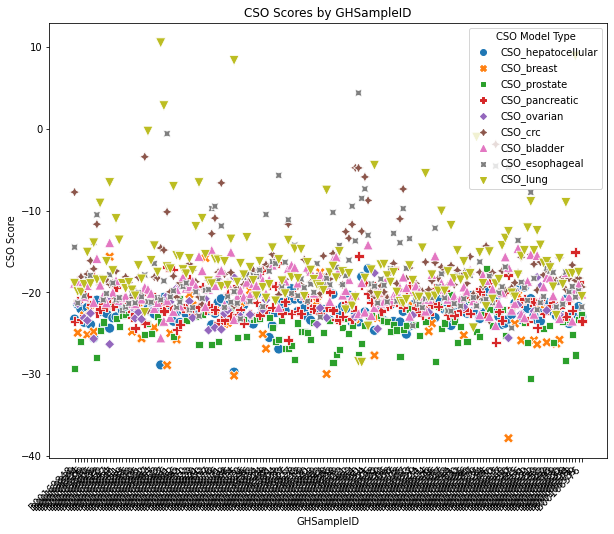

In [ ]:


# Creating the scatter plot
plt.figure(figsize=(20, 18))
sns.scatterplot(data=cancerTypeModelScores_new, x='GHSampleID', y='cso_score', hue='cso_model_type', style='cso_model_type', s=100)

# Improve legibility by rotating the x-axis labels if there are many samples
plt.xticks(rotation=45, ha='right')

# Adding a title and labels
plt.title('CSO Scores by GHSampleID')
plt.xlabel('GHSampleID')
plt.ylabel('CSO Score')

# Show a legend with the model types
plt.legend(title='CSO Model Type')

# Show the plot
plt.show()


In [22]:
top_prd_df = topn_predictions(avg_results=cancerTypeModelScores,
                               top_n=1,
                               index_cols=[])

In [122]:
top_prd_df = topn_predictions(avg_results=cancerTypeModelScores_new,
                               top_n=2,
                               index_cols=[])
top_prd_df.shape

(320, 138)

In [ ]:
top_prd_df_test = top_prd_df[top_prd_df["cso_prediction"] == "hepatocellular"]
top_prd_df_test

,unique_sample_id,Pancancer,cso_model_type,cso_score,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Sample Type,Sample Subtype,(Nof1) Cancer Type,Cancer Stage,Tumor Type,Molecular Marker,Patient age at Sample Collection,Patient Year of Birth (YYYY),Patient Sex,Patient Pregnancy / Transplant history,Patient Treatment Information,Investigator / PI,Site Number,customersampleid,requestcreatedt,sample_received_date,cancerstage,index,index2,Description,Index Name,fc_dir,WellId,From [bp],To [bp],Average Size [bp],Conc. [ng/µl],Region Molarity [nmol/l],% of Total,Batch_ID,call,ldt_reportable,ruo_reportable,Final_RUO_call,Start,on_OMNI,variant_comment,is_deletion,molecule_count,estimated_copy_number,region_methyl_score,region_methyl_molecules,hrd_status,prob_hrd_pos,lst_score,loh_score,methyl_pred_type,sample_LR_methyl_score,methyl_score_bladder_lr,methyl_score_breast_lr,methyl_score_crc_lr,methyl_score_lung_lr,msi_score,hyper_flag,runid,chry_nonsingleton,cnv_hyper_score,contam_vscore,estimated_contam_level,hotspot_non_singleton_coverage,hotspot_umol_gc_iqr,hypo_on_target_rate,mapd,methyl_hyper_pos_highcg_count,methyl_neg_capture,methyl_pos_capture_max,methyl_pos_capture_min,sample_contamination_pct,warning,fc_dir_new,fc_dir_ori,cnv_qc_file_path,run_sample_id,predicted_sex,provided_sex,Pancancer_call,cso_prediction,CSO_rank
949,B00166542_220725_A00770_0531_BHHKC7DSX3,-16.219189,CSO_crc,-16.510147,CTMX-001,IVT_134010_01,A0529110,B00166542,IVT_134010,NaN,1.0,SUCCESS,NaN,SNV,NaN,KMT2D,12,49431648.0,35.0,R3164Q,C>T,c.9491G>A,NM_003482.4,50.82,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV56431056,rs587783730,Likely_benign,168932.0,NaN,NaN,4927.0,0.33,NaN,-1.355,Detected,0.000017,NaN,Not evaluable,Not Detected,30.160,3.0,0,NaN,NaN,10/06/2022,"Oral cavity Squamous cell carcinoma, invasive",Not Applicable,Not Applicable,Plasma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IVT_134010_01,2022-06-13T10:30:53.000Z,2022-06-08T12:00:00.000Z,NaN,TTTGCGCCCT,ACGCATCTTT,Shortened_Targeted_SEQ:Unknown:Pharma,EIO_PlateD_B11,/ghds/omni_v2/flowcells/220725_A00770_0531_BHHKC7DSX3_PROD38_AP3.Sirius-1.0.0.740-master-2ec4e96_20220727-192614,B11,100,450,208,0.464,3.57,23.62,PROD-38,1.0,0,1,1,49431647.0,Yes,NaN,NaN,NaN,NaN,NaN,NaN,HRD_Neg,0.205054,0,1,lung,10.442692,6.780148,4.272955,4.577335,10.442692,5,NaN,220725_A00770_0531_BHHKC7DSX3,0.0,0.0,5.0,0.00144,4643.0,1.100,0.83,0.04,199010.0,0.000121,1.23084,1.23084,0.02,NaN,/ghsfa/projects/omni_v2/users/schen/methylation_data/s3-mcm-mbd-counts/mb_crc_12cpg_regular/220725_A00770_0531_BHHKC7DSX3_PROD38_AP3.Sirius-1.0.0-RLS_20221023-111718,/ghsfa/projects/omni_v2/flowcells/220725_A00770_0531_BHHKC7DSX3_PROD38_AP3.Sirius-1.0.0-RLS_20221023-111718,/ghsfa/projects/omni_v2/flowcells/220725_A00770_0531_BHHKC7DSX3_PROD38_AP3.Sirius-1.0.0-RLS_20221023-111718/B00166542/B00166542.ghcnv_qc.hdr.tsv,B00166542,Male,Male,True,digestive,1
1429,B00166542_220725_A00770_0531_BHHKC7DSX3,-16.219189,CSO_lung,-16.982353,CTMX-001,IVT_134010_01,A0529110,B00166542,IVT_134010,NaN,1.0,SUCCESS,NaN,SNV,NaN,KMT2D,12,49431648.0,35.0,R3164Q,C>T,c.9491G>A,NM_003482.4,50.82,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV56431056,rs587783730,Likely_benign,168932.0,NaN,NaN,4927.0,0.33,NaN,-1.355,Detected,0.000017,NaN,Not evaluable,Not Detected,30.160,3.0,0,NaN,NaN,10/

## Visualizations
### Utility function

In [23]:
def plot_accuracy_precision_heatmap(top_prediction_df, description, type_metric = "sensitivity", col_scheme_val = "lightgreyteal"):
    df_accuracy = get_contingency(cancerTypeModelScores_top=top_prediction_df,
        metric_type = type_metric)
    
    if type_metric=="sensitivity":
        df_accuracy.rename(
            columns = {
                "sensitivity":"Accuracy"
            },
            inplace=True
        )
        type_metric="Accuracy"
    
    return heatmap_contingency(
        x_col="sample_group",
        y_col="CSO_prediction",
        height_fig=250,
        width_fig=400,
        color_col=type_metric,
        col_scheme=col_scheme_val,
        df = df_accuracy
    ).properties(
            title = description
        )

In [24]:
top_prd_df.head()

,unique_sample_id,Pancancer,cso_model_type,cso_score,sample_id,batch_id,specimen_type,hyper_enrichment_panel,hypo_enrichment_panel,qc_status,...,lesion_location,sex,assay_version,Pancancer_call,cnv_qc_file_path,run_sample_id,predicted_sex,provided_sex,cso_prediction,CSO_rank
36172,A084081201_240303_A02019_0066_AHWJJYDSX7,-9.634654,CSO_pancreatic,-9.958181,A084081201,PS3C-562-LDT,NaN,S3-Gen-v1.2-Epi-v1.1,S3-Gen-v1.2,FAIL,...,NaN,F,NaN,True,/ghds/ivd/flowcentral/240303_A02019_0066_AHWJJ...,A084081201,Female,Female,pancreatic,1
78057,A087999801_240224_A01835_0230_AHTFKNDSX7,-21.620789,CSO_lung,-15.897420,A087999801,PS3C-531-LDT,NaN,S3-Gen-v1.2-Epi-v1.1,S3-Gen-v1.2,PASS,...,NaN,F,NaN,False,/ghds/ivd/flowcentral/240224_A01835_0230_AHTFK...,A087999801,Female,Female,lung,1
27968,A088500801_240202_A01467_0454_BHNM2GDSX7,0.131486,CSO_pancreatic,-7.953887,A088500801,PS3C-431-LDT,NaN,S3-Gen-v1.2-Epi-v1.1,S3-Gen-v1.2,PASS,...,NaN,M,NaN,True,/ghds/ivd/flowcentral/240202_A01467_0454_BHNM2...,A088500801,Male,Male,pancreatic,1
74055,A088625001_240211_A01907_0226_AHNNWJDSX7,-20.856934,CSO_lung,-17.072479,A088625001,PS3C-463-LDT,NaN,S3-Gen-v1.2-Epi-v1.1,S3-Gen-v1.2,PASS,...,NaN,F,NaN,False,/ghds/ivd/flowcentral/240211_A01907_0226_AHNNW...,A088625001,Female,Female,lung,1
75900,A088927001_240128_A00277_0987_BHMLHGDSX7,-22.472032,CSO_lung,-17.438985,A088927001,PS3C-406-LDT,NaN,S3-Gen-v1.2-Epi-v1.1,S3-Gen-v1.2,PASS,...,NaN,F,NaN,False,/ghds/ivd/flowcentral/240128_A00277_0987_BHMLH...,A088927001,Female,Female,lung,1


In [114]:
top_prd_df.shape

NameError: name 'top_prd_df' is not defined

In [25]:
top_prd_df[top_prd_df.Pancancer_call].sample_group.value_counts().sum()

6669

### Pancancer sensitivity

In [26]:
pancancer_sensitivity = pd.DataFrame({
    "sensitivity": top_prd_df[top_prd_df.Pancancer_call].sample_group.value_counts()/top_prd_df.sample_group.value_counts(),
    "N": top_prd_df.sample_group.value_counts()
}
)
pancancer_sensitivity["metric"] = "sensitivity"
pancancer_sensitivity["N"] = pancancer_sensitivity["N"].astype(str)
pancancer_sensitivity["sample_n"] = pancancer_sensitivity.index + "(N=" + pancancer_sensitivity["N"] + ")"
heatmap_contingency(
    df = pancancer_sensitivity,
    y_col="sample_n",
    x_col="metric",
    color_col="sensitivity",
    col_scheme="lightgreyred", width_fig=100
)


alt.LayerChart(...)

### Top prediction accuracy heatmap

In [27]:
plot_accuracy_precision_heatmap(
    top_prediction_df=top_prd_df[top_prd_df.Pancancer_call],
    type_metric="sensitivity",
    col_scheme_val = "lightgreyred",
    description="Locked NCI Model"

)

alt.LayerChart(...)

### Top prediction precision heatmap

In [28]:
plot_accuracy_precision_heatmap(
    top_prediction_df=top_prd_df[top_prd_df.Pancancer_call],
    type_metric="precision",
    description="Locked NCI Model"

)

alt.LayerChart(...)

### Top 2 predictions based accuracy by cancer type

In [30]:

def get_heatmap_top2(cancer_type_scores_df, description):
    cancerTypeModelScores_topn = topn_predictions(avg_results=cancer_type_scores_df,
                               top_n=2,
                               index_cols=[])
    cancerTypeModelScores_topn = cancerTypeModelScores_topn[cancerTypeModelScores_topn.Pancancer_call]

    sensitivity_cso =  cancerTypeModelScores_topn.groupby(
        ["sample_group"]
    ).apply(
        lambda x: 
        np.sum(x.groupby("unique_sample_id"
    ).apply(
        lambda y: np.sum(
            y.cso_prediction==y.sample_group
        )
    ))/x.patient_id.nunique()
    ).drop(['crc','esophageal'], axis=0)

    ### crc_esophageal_sensitivity
    crc_esophageal_scores = cancerTypeModelScores_topn[cancerTypeModelScores_topn.sample_group.isin(['crc','esophageal','gastric'])].copy()
    crc_esophageal_scores.loc[crc_esophageal_scores.cso_prediction=='crc',"cso_prediction"]="digestive"
    crc_esophageal_scores.loc[crc_esophageal_scores.cso_prediction=='esophageal',"cso_prediction"]="digestive"

    crc_esophageal_sensitivity = crc_esophageal_scores[["unique_sample_id","sample_group","cso_prediction","patient_id"]].drop_duplicates().groupby(
            ["sample_group"]
        ).apply(
            lambda x: 
            np.sum(x.groupby("unique_sample_id"
        ).apply(
            lambda y: np.sum(
                y.cso_prediction=="digestive"
            )
        ))/x.patient_id.nunique()
        )
    
    sensitivity_cso = pd.concat([sensitivity_cso, crc_esophageal_sensitivity], axis=0)

    sensitivity_cso = pd.concat(
        [sensitivity_cso,
        cancerTypeModelScores_topn[cancerTypeModelScores_topn.Pancancer_call].groupby("sample_group")["patient_id"].nunique()],
     axis=1
).rename(
    columns={0:"Accuracy",
             "patient_id":"num_samples"}
)
    print(sensitivity_cso.head())
    sensitivity_cso["num_samples"] = sensitivity_cso["num_samples"].astype(str)
    sensitivity_cso["sample_n"] = sensitivity_cso.index + "(N=" + sensitivity_cso["num_samples"] + ")"
    
    return heatmap_contingency(
        y_col="sample_n",
        x_col="",
        color_col="Accuracy",
        col_scheme='lightgreyred',
        width_fig=100,
        df = sensitivity_cso
    ).properties(
            title = description
        ), sensitivity_cso

plot, top2perf = (get_heatmap_top2(cancerTypeModelScores, description="Locked NCI model"))

                Accuracy  num_samples
sample_group                         
bladder         0.920455           88
breast          0.847906         1624
hepatocellular  0.924370          119
lung            0.966422         1638
ovarian         0.882353          102


In [44]:
plot

alt.LayerChart(...)

## Accuracy and Precision by TF

In [32]:
tf_fn = "/screening/analysis/2024_03_27_cso_by_tumor_fraction_PP/data/All_s3_goldmine_epitfv2_aggregated.tsv"
tf_df = pd.read_table(
    tf_fn
)
print(tf_df.shape)
tf_df = tf_df[["unique_sample_id","epiTFnewfit3_pan"]].merge(top_prd_df,
                     on = "unique_sample_id") ## merge with top CSO call


print(top_prd_df.shape, tf_df.shape)
print(top_prd_df[top_prd_df.Pancancer_call].shape, tf_df[tf_df.Pancancer_call].shape)

(10277, 83)
(9079, 79) (5220, 80)
(6669, 79) (3664, 80)


/home/pparsana/miniconda3/envs/analysis_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (40,70,79) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [33]:
tf_df.sample_group.value_counts()

lung              1448
breast            1256
prostate           751
crc                747
pancreatic         464
esophageal         308
ovarian            105
hepatocellular      74
bladder             67
Name: sample_group, dtype: int64

In [34]:
tf_df["CSO_call"] = tf_df.apply(
    lambda x: x['cso_prediction'] in dict_cancertype_pred.get(x.sample_group),
    axis=1
) ## Get true or false for the top CSO call

In [35]:
tf_column = "epiTFnewfit3_pan"
n_quantile = 20
tf_df["bin_"+tf_column] = pd.cut(tf_df[tf_column], n_quantile).astype(str)
tf_df.head()

,unique_sample_id,epiTFnewfit3_pan,Pancancer,cso_model_type,cso_score,sample_id,batch_id,specimen_type,hyper_enrichment_panel,hypo_enrichment_panel,...,assay_version,Pancancer_call,cnv_qc_file_path,run_sample_id,predicted_sex,provided_sex,cso_prediction,CSO_rank,CSO_call,bin_epiTFnewfit3_pan
0,A095210901_240128_A01902_0296_BHMLHVDSX7,0.000193,-21.373849,CSO_crc,-17.764979,A095210901,PS3C-406-LDT,NaN,S3-Gen-v1.2-Epi-v1.1,S3-Gen-v1.2,...,NaN,False,/ghds/ivd/flowcentral/240128_A01902_0296_BHMLH...,A095210901,Male,Male,digestive,1,False,"(-0.00139, 0.0696]"
1,A097952401_240303_A01112_0468_AHWJLNDSX7,0.000207,-22.261010,CSO_lung,-15.955297,A097952401,PS3C-562-LDT,NaN,S3-Gen-v1.2-Epi-v1.1,S3-Gen-v1.2,...,NaN,False,/ghds/ivd/flowcentral/240303_A01112_0468_AHWJL...,A097952401,Female,Female,lung,1,False,"(-0.00139, 0.0696]"
2,A097698301_240301_A02019_0063_BHTKJWDSX7,0.000481,-20.791121,CSO_crc,-17.678892,A097698301,PS3C-552-LDT,NaN,S3-Gen-v1.2-Epi-v1.1,S3-Gen-v1.2,...,NaN,False,/ghds/ivd/flowcentral/240301_A02019_0063_BHTKJ...,A097698301,Male,Male,digestive,1,False,"(-0.00139, 0.0696]"
3,A097347201_240226_A01422_0538_AHTGCGDSX7,0.000303,-21.940853,CSO_lung,-16.995061,A097347201,PS3C-539-LDT,NaN,S3-Gen-v1.2-Epi-v1.1,S3-Gen-v1.2,...,NaN,False,/ghds/ivd/flowcentral/240226_A01422_0538_AHTGC...,A097347201,Male,Male,lung,1,False,"(-0.00139, 0.0696]"
4,A096804001_240219_A01361_0608_BHTKNYDSX7,0.376451,-3.654918,CSO_breast,-6.297396,A096804001,PS3C-506-LDT,NaN,S3-Gen-v1.2-Epi-v1.1,S3-Gen-v1.2,...,NaN,True,/ghds/ivd/flowcentral/240219_A01361_0608_BHTKN...,A096804001,Female,Female,breast,1,True,"(0.348, 0.417]"


<AxesSubplot:>

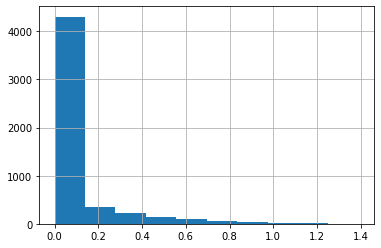

In [36]:
%matplotlib inline
tf_df[tf_column].hist()

### Log scaled bins

In [37]:
tf_column = "epiTFnewfit3_pan"
n_quantile = len([-0.00001,0.0001,0.001,0.005, 0.01,0.1,1.4])
tf_df["bin_"+tf_column], cutoff_array = pd.cut(tf_df[tf_column], bins=[-0.00001,0.0001,0.001,0.005, 0.01,0.1,1.4], 
                                               retbins=True)
tf_df["bin_"+tf_column] = tf_df["bin_"+tf_column].astype(str)
tf_df.head()

,unique_sample_id,epiTFnewfit3_pan,Pancancer,cso_model_type,cso_score,sample_id,batch_id,specimen_type,hyper_enrichment_panel,hypo_enrichment_panel,...,assay_version,Pancancer_call,cnv_qc_file_path,run_sample_id,predicted_sex,provided_sex,cso_prediction,CSO_rank,CSO_call,bin_epiTFnewfit3_pan
0,A095210901_240128_A01902_0296_BHMLHVDSX7,0.000193,-21.373849,CSO_crc,-17.764979,A095210901,PS3C-406-LDT,NaN,S3-Gen-v1.2-Epi-v1.1,S3-Gen-v1.2,...,NaN,False,/ghds/ivd/flowcentral/240128_A01902_0296_BHMLH...,A095210901,Male,Male,digestive,1,False,"(0.0001, 0.001]"
1,A097952401_240303_A01112_0468_AHWJLNDSX7,0.000207,-22.261010,CSO_lung,-15.955297,A097952401,PS3C-562-LDT,NaN,S3-Gen-v1.2-Epi-v1.1,S3-Gen-v1.2,...,NaN,False,/ghds/ivd/flowcentral/240303_A01112_0468_AHWJL...,A097952401,Female,Female,lung,1,False,"(0.0001, 0.001]"
2,A097698301_240301_A02019_0063_BHTKJWDSX7,0.000481,-20.791121,CSO_crc,-17.678892,A097698301,PS3C-552-LDT,NaN,S3-Gen-v1.2-Epi-v1.1,S3-Gen-v1.2,...,NaN,False,/ghds/ivd/flowcentral/240301_A02019_0063_BHTKJ...,A097698301,Male,Male,digestive,1,False,"(0.0001, 0.001]"
3,A097347201_240226_A01422_0538_AHTGCGDSX7,0.000303,-21.940853,CSO_lung,-16.995061,A097347201,PS3C-539-LDT,NaN,S3-Gen-v1.2-Epi-v1.1,S3-Gen-v1.2,...,NaN,False,/ghds/ivd/flowcentral/240226_A01422_0538_AHTGC...,A097347201,Male,Male,lung,1,False,"(0.0001, 0.001]"
4,A096804001_240219_A01361_0608_BHTKNYDSX7,0.376451,-3.654918,CSO_breast,-6.297396,A096804001,PS3C-506-LDT,NaN,S3-Gen-v1.2-Epi-v1.1,S3-Gen-v1.2,...,NaN,True,/ghds/ivd/flowcentral/240219_A01361_0608_BHTKN...,A096804001,Female,Female,breast,1,True,"(0.1, 1.4]"


In [38]:
tf_df["bin_"+tf_column+"_n"] = tf_df.groupby(['sample_group',"bin_"+tf_column])["sample_id"].transform(lambda x:x.shape[0]) ## Total number of samples per bin per sample group

## Compute accuracy based on top prediction per cancer type and TF quantile bin
tf_sens = tf_df.groupby(
    ["bin_"+tf_column,"sample_group","bin_"+tf_column+"_n"]
     )[["CSO_call"]].agg(lambda x:np.sum(x)/x.shape[0]).reset_index().rename(columns={"CSO_call":"Accuracy"})

tf_sens = tf_sens[~tf_sens["Accuracy"].isna()] ## Drop entries where accuracy is NaN

tf_sens["Accuracy_N"] = tf_sens.Accuracy.round(2).astype(str) + "\n(N=" + tf_sens["bin_"+tf_column+"_n"].astype(str) + ")"

tf_sens.head()

,bin_epiTFnewfit3_pan,sample_group,bin_epiTFnewfit3_pan_n,Accuracy,Accuracy_N
0,"(-1e-05, 0.0001]",bladder,1,0.000000,0.0\n(N=1)
1,"(-1e-05, 0.0001]",breast,110,0.000000,0.0\n(N=110)
2,"(-1e-05, 0.0001]",crc,34,0.235294,0.24\n(N=34)
3,"(-1e-05, 0.0001]",esophageal,15,0.000000,0.0\n(N=15)
4,"(-1e-05, 0.0001]",lung,162,0.858025,0.86\n(N=162)


In [39]:
alt.Chart(tf_sens).mark_rect().encode(
    y=alt.Y(
        "sample_group:N",
        axis=alt.Axis(
            labelFontSize=14, titleFontSize=16
        )
    ),
    x=alt.X(
        "bin_epiTFnewfit3_pan:N", title="Binned TF v2",
        axis=alt.Axis(
            labelFontSize=14, titleFontSize=16
        ),
        sort = [-0.00001,0.0001,0.001,0.005, 0.01,0.1,1.4]
    ),
    color=alt.Color("Accuracy:Q",title="Accuracy",scale=alt.Scale(scheme="lightgreyred"))
).properties(
    width=n_quantile*100, height=200
)+ alt.Chart(tf_sens).mark_text(size=14).encode(
    y=alt.Y(
        "sample_group:N",
        axis=alt.Axis(
            labelFontSize=14, titleFontSize=16
        )
    ),
    x=alt.X(
        "bin_epiTFnewfit3_pan:N", title="Binned TF v2",
        axis=alt.Axis(
            labelFontSize=14, titleFontSize=16
        ),
        sort = [-0.00001,0.0001,0.001,0.005, 0.01,0.1,1.4]
    ),
    text = "Accuracy_N",
    color=alt.condition(
        alt.datum.Accuracy<=0.5,
        alt.value("black"),
        alt.value("white")
    )
).properties(
    width=n_quantile*100, height=200
)

alt.LayerChart(...)

### Cumulative precision and sensitivity by TF to see evaluable samples

In [40]:
cumulative_sensitivity = {}

for each in cutoff_array[:-1]:
    temp_df = tf_df[tf_df[tf_column]>=each].copy()
    temp_df["sample_n"] = temp_df.groupby(['sample_group'])["sample_id"].transform(lambda x:x.shape[0]) ## Total number of samples per bin per sample group

    ## Compute accuracy based on top prediction per cancer type and TF quantile bin
    tf_sens = temp_df.groupby(
    ["sample_group","sample_n"]
     )[["CSO_call"]].agg(lambda x:np.sum(x)/x.shape[0]).reset_index().rename(columns={"CSO_call":"Accuracy"})
    
    tf_sens = tf_sens[~tf_sens["Accuracy"].isna()] ## Drop entries where accuracy is NaN
    tf_sens["Accuracy_N"] = tf_sens.Accuracy.round(2).astype(str) + "\n(N=" + tf_sens["sample_n"].astype(str) + ")"
    cumulative_sensitivity[">="+str(each)+":"+str(np.round(temp_df.shape[0]/tf_df.shape[0],2)*100)+"% evaluable"] = tf_sens.copy()

cumulative_sensitivity = pd.concat(cumulative_sensitivity, axis=0).reset_index().drop(columns="level_1").rename(
    columns={
        "level_0":"Evaluable Samples"
    }
)


,Evaluable Samples,sample_group,sample_n,Accuracy,Accuracy_N
0,>=-1e-05:100.0% evaluable,bladder,67,0.611940,0.61\n(N=67)
1,>=-1e-05:100.0% evaluable,breast,1256,0.560510,0.56\n(N=1256)
2,>=-1e-05:100.0% evaluable,crc,747,0.878179,0.88\n(N=747)
3,>=-1e-05:100.0% evaluable,esophageal,308,0.730519,0.73\n(N=308)
4,>=-1e-05:100.0% evaluable,hepatocellular,74,0.702703,0.7\n(N=74)
5,>=-1e-05:100.0% evaluable,lung,1448,0.901934,0.9\n(N=1448)
6,>=-1e-05:100.0% evaluable,ovarian,105,0.390476,0.39\n(N=105)
7,>=-1e-05:100.0% evaluable,pancreatic,464,0.482759,0.48\n(N=464)
8,>=-1e-05:100.0% evaluable,prostate,751,0.241012,0.24\n(N=751)
9,>=0.0001:92.0% evaluable,bladder,66,0.621212,0.62\n(N=66)


In [41]:
alt.Chart(cumulative_sensitivity).mark_rect().encode(
    y=alt.Y(
        "sample_group:N",
        axis=alt.Axis(
            labelFontSize=14, titleFontSize=16
        )
    ),
    x=alt.X(
        "Evaluable Samples:N", title="% Evaluable samples by Tumor Fraction",
        axis=alt.Axis(
            labelFontSize=14, titleFontSize=16
        ),
        sort = [-0.00001,0.0001,0.001,0.005, 0.01,0.1,1.4]
    ),
    color=alt.Color("Accuracy:Q",title="Accuracy",scale=alt.Scale(scheme="lightgreyred"))
).properties(
    width=n_quantile*100, height=200
)+ alt.Chart(cumulative_sensitivity).mark_text(size=14).encode(
    y=alt.Y(
        "sample_group:N",
        axis=alt.Axis(
            labelFontSize=14, titleFontSize=16
        )
    ),
    x=alt.X(
        "Evaluable Samples:N", title="% Evaluable samples by Tumor Fraction",
        axis=alt.Axis(
            labelFontSize=14, titleFontSize=16
        ),
        sort = [-0.00001,0.0001,0.001,0.005, 0.01,0.1,1.4]
    ),
    text = "Accuracy_N",
    color=alt.condition(
        alt.datum.Accuracy<=0.5,
        alt.value("black"),
        alt.value("white")
    )
).properties(
    width=n_quantile*100, height=200
)

alt.LayerChart(...)

In [42]:
cumulative_precision = {}

for each in cutoff_array[:-1]:
    temp_df = tf_df[tf_df[tf_column]>=each].copy()
    temp_df["sample_n"] = temp_df.groupby(['cso_prediction'])["sample_id"].transform(lambda x:x.shape[0]) ## Total number of samples per bin per sample group

    ## Compute accuracy based on top prediction per cancer type and TF quantile bin
    tf_sens = temp_df.groupby(
    ["cso_prediction","sample_n"]
     )[["CSO_call"]].agg(lambda x:np.sum(x)/x.shape[0]).reset_index().rename(columns={"CSO_call":"Precision"})
    
    tf_sens = tf_sens[~tf_sens["Precision"].isna()] ## Drop entries where accuracy is NaN
    tf_sens["Precision_N"] = tf_sens.Precision.round(2).astype(str) + "\n(N=" + tf_sens["sample_n"].astype(str) + ")"
    cumulative_precision[">="+str(each)+":"+str(np.round(temp_df.shape[0]/tf_df.shape[0],2)*100)+"% evaluable"] = tf_sens.copy()

cumulative_precision = pd.concat(cumulative_precision, axis=0).reset_index().drop(columns="level_1").rename(
    columns={
        "level_0":"Evaluable Samples"
    }
)
cumulative_precision


,Evaluable Samples,cso_prediction,sample_n,Precision,Precision_N
0,>=-1e-05:100.0% evaluable,bladder,83,0.493976,0.49\n(N=83)
1,>=-1e-05:100.0% evaluable,breast,711,0.990155,0.99\n(N=711)
2,>=-1e-05:100.0% evaluable,digestive,1534,0.574316,0.57\n(N=1534)
3,>=-1e-05:100.0% evaluable,hepatocellular,100,0.520000,0.52\n(N=100)
4,>=-1e-05:100.0% evaluable,lung,2292,0.569808,0.57\n(N=2292)
5,>=-1e-05:100.0% evaluable,ovarian,61,0.672131,0.67\n(N=61)
6,>=-1e-05:100.0% evaluable,pancreatic,257,0.871595,0.87\n(N=257)
7,>=-1e-05:100.0% evaluable,prostate,182,0.994505,0.99\n(N=182)
8,>=0.0001:92.0% evaluable,bladder,81,0.506173,0.51\n(N=81)
9,>=0.0001:92.0% evaluable,breast,711,0.990155,0.99\n(N=711)


In [43]:
alt.Chart(cumulative_precision).mark_rect().encode(
    y=alt.Y(
        "cso_prediction:N",
        axis=alt.Axis(
            labelFontSize=14, titleFontSize=16
        )
    ),
    x=alt.X(
        "Evaluable Samples:N", title="% Evaluable samples by Tumor Fraction",
        axis=alt.Axis(
            labelFontSize=14, titleFontSize=16
        ),
        sort = [-0.00001,0.0001,0.001,0.005, 0.01,0.1,1.4]
    ),
    color=alt.Color("Precision:Q",title="Precision",scale=alt.Scale(scheme="yellowgreen"))
).properties(
    width=n_quantile*100, height=200
)+ alt.Chart(cumulative_precision).mark_text(size=14).encode(
    y=alt.Y(
        "cso_prediction:N",
        axis=alt.Axis(
            labelFontSize=14, titleFontSize=16
        )
    ),
    x=alt.X(
        "Evaluable Samples:N", title="% Evaluable samples by Tumor Fraction",
        axis=alt.Axis(
            labelFontSize=14, titleFontSize=16
        ),
        sort = [-0.00001,0.0001,0.001,0.005, 0.01,0.1,1.4]
    ),
    text = "Precision_N",
    color=alt.condition(
        alt.datum.Precision<=0.6,
        alt.value("black"),
        alt.value("white")
    )
).properties(
    width=n_quantile*100, height=200
)

alt.LayerChart(...)